# Mutual Information between Filters

## Preparation

### Imports

In [ ]:
import matplotlib.pyplot as plt
#import cupy as np
import numpy as np

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

2023-05-10 04:25:31.659306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 04:25:31.740858: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-10 04:25:31.740872: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-10 04:25:32.118774: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [ ]:
!nvidia-smi

Wed May 10 04:25:39 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti      Off| 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8               17W / 350W|    151MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Data preparation

In [ ]:
# load MNIST
((trainX, trainY), (testX, testY)) = mnist.load_data()

# edit shapes to make Keras happy
trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

# do a train/validation split with the same random state as the trained model
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, random_state = 0)

# save the integer labels
trainY_int = trainY
validationY_int = validationY
testY_int = testY

# turn labels into one-hot vectors
trainY = to_categorical(trainY, 10)
validationY = to_categorical(validationY, 10)
testY = to_categorical(testY, 10)

### Extract Activations and Outputs

In [ ]:
# load a model (from tensorflow.keras)
model = load_model('CNN_MNIST_baseline')

# extracts the outputs of all layers
layer_outputs = [layer.output for layer in model.layers] 

# creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

# returns a list of Numpy arrays: one array per layer activation
train_activations = activation_model.predict(trainX)
test_activations = activation_model.predict(testX)

# returns the model class predictions
predicted_trainY = model.predict(trainX).argmax(axis = 1)
predicted_testY = model.predict(testX).argmax(axis = 1)

# get activations from the convolutional layer
layer = 2
train_activation = train_activations[layer]
test_activation = test_activations[layer]

313/313 [==============================] - 0s 1ms/step


In [ ]:
test_activation.shape

(10000, 26, 26, 16)

## Compute MI of Pairs of Pixels in 2 Filters

In [ ]:
from sklearn.metrics import mutual_info_score
from mutual_info import calc_MI
from multiprocessing import Pool, cpu_count

def compute_MI_matrix(inputs):
    k, l, data = inputs
    
    # extract specified filter activations
    f1_data = data[:,:,:,k]
    f2_data = data[:,:,:,l]

    # dimension of filters
    d = 26*26

    # reshape to d-vectors
    f1_data = f1_data.reshape([10000, d])
    f2_data = f2_data.reshape([10000, d])

    # initialize MI matrix
    MI_matrix = np.zeros([d, d])

    # fill in the MI matrix
    pool = Pool(processes = None)
    batch_size = 100

    for i in range(d):
        if i % 100 == 0:
            print(i, flush=True)
        #MI_matrix[i:i+batch_size,:] = np.array(pool.map(calc_MI, ((f1_data[:,i:i+batch_size], f2_data[:,j:j+batch_size], 100) for j in range(d)))).T
        MI_matrix[i] = pool.map(calc_MI, ((f1_data[:,i], f2_data[:,j], 100) for j in range(d)))
    
    print(f'Finished MI matrix for filter {k} and filter {l}', flush=True)
    
    return MI_matrix

In [ ]:
MI_matrix_01 = compute_MI_matrix((0, 1, test_activation))

0
100
200
300
400
500
600
Finished MI matrix for filter 0 and filter 1


### Mean MI

Text(0.5, 1.0, 'Mean MI of Filter 0 Pixels to All Filter 1 Pixels')

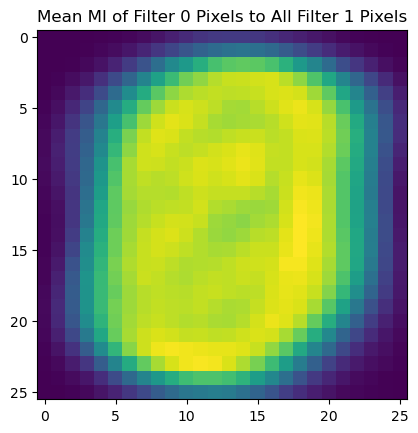

In [ ]:
mean_MI = MI_matrix_01.mean(axis=0).reshape([26, 26])

plt.imshow(mean_MI)
plt.title('Mean MI of Filter 0 Pixels to All Filter 1 Pixels')

In other words, we computed

$$MI\left(f^0_{ij}, f^1_{kl}\right),\quad \text{for }i, j, k, l\in\{0,1,...,25\}$$

i.e., the mutual information between all pairs of pixels from filter 0 ($f^0$) and pixels from filter 1 ($f^1$) to get a $26^2\times 26^2$ mutual information matrix. We took a row means to get mean MI between each $f^0$ pixel and the whole of $f^1$, and then reshaped it into a $26\times 26$ image.

This simply looks like a blob that is more intense near pixels where MNIST strokes typically occur. This makes sense, as both filters are likely to be 0 around the periphery where none of the action is happening.

### MI for Identical Pixels in Different Filters

In [ ]:
paired_pixel_MI = []

for i in range(676):
    # if pixel number in two images match up, append MI
    paired_pixel_MI.append(MI_matrix_01[i,i])
            
# reshape to filter dimensions 26x26
paired_pixel_MI = np.array(paired_pixel_MI).reshape([26, 26])

Text(0.5, 1.0, 'MI between Pixels in the same Location in Filters 0 and 1')

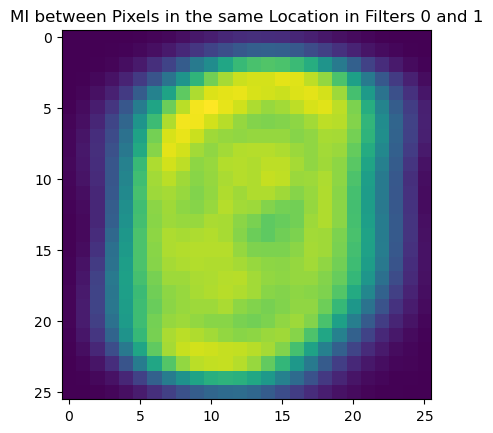

In [ ]:
plt.imshow(paired_pixel_MI)
plt.title('MI between Pixels in the same Location in Filters 0 and 1')

It looks the same, but we observe the MI is far higher with the paired pixels numerically below.

In [ ]:
print('MMI', np.min(mean_MI), np.max(mean_MI))
print('PPMI', np.min(paired_pixel_MI), np.max(paired_pixel_MI))

MMI 6.092433931839497e-16 0.2242647187413921
PPMI 0.0 2.005390417580291


Let's try plotting them with the same color scale...

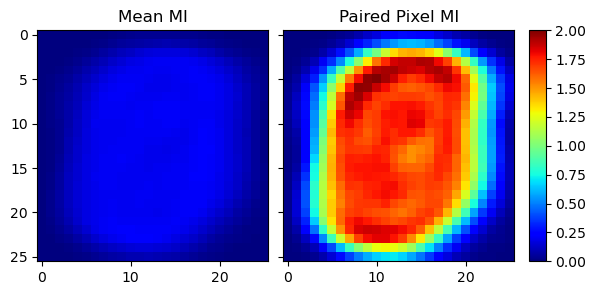

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
for i, ax in enumerate(grid):
    if i == 0:
        im = ax.imshow(mean_MI, vmin=0, vmax=2, cmap='jet')
        ax.set_title('Mean MI')
    else:
        im = ax.imshow(paired_pixel_MI, vmin=0, vmax=2, cmap='jet')
        ax.set_title('Paired Pixel MI')
    
# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

Now, we see that while they have the same structure, the intensity is far greater with PPMI.

## Class-Specific MI

The analysis above is for all MNIST data, even images from different classes, so let's try to do a similar analysis for each class.

In [ ]:
import time

def compute_MI_matrix_classes(inputs):
    k, l, all_data, labels = inputs
    num_classes = np.unique(labels).shape[0]
    
    # dimension of filters
    d = 26*26
    
    MI_matrices = []
    
    for m in range(num_classes):
        
        tic = time.perf_counter()        
        #print('Computing MI matrix for class', m)
        
        data = all_data[labels == m]
        
        # extract specified filter activations
        f0_data = data[:,:,:,k]
        f1_data = data[:,:,:,l]

        # reshape to d-vectors
        f0_data = f0_data.reshape([data.shape[0], d])
        f1_data = f1_data.reshape([data.shape[0], d])

        # initialize MI matrix
        MI_matrix = np.zeros([d, d])
        
        # creating a pool for multiprocessing
        pool = Pool(processes = None)

        # fill in MI matrix one row at a time
        for i in range(d):
            #if i % 100 == 0: print(i, flush=True)
            MI_matrix[i] = pool.map(calc_MI, ((f0_data[:,i], f1_data[:,j], 100) for j in range(d)))
   
        toc = time.perf_counter()
        print('Finished with MI matrix for class %d in %.2f seconds' % (m, toc - tic))
        
        MI_matrices.append(MI_matrix)
    
    return MI_matrices

In [ ]:
MI_matrices = compute_MI_matrix_classes((0,1,test_activation,testY_int))

Finished with MI matrix for class 0 in 22.91 seconds
Finished with MI matrix for class 1 in 24.44 seconds
Finished with MI matrix for class 2 in 23.49 seconds
Finished with MI matrix for class 3 in 22.19 seconds
Finished with MI matrix for class 4 in 21.75 seconds
Finished with MI matrix for class 5 in 21.01 seconds
Finished with MI matrix for class 6 in 23.34 seconds
Finished with MI matrix for class 7 in 22.59 seconds
Finished with MI matrix for class 8 in 22.82 seconds
Finished with MI matrix for class 9 in 23.33 seconds


In [ ]:
for i in range(10):
    PPMI = MI_matrices[i]
    print('Class', i, 'PPMI range:', np.min(PPMI), np.max(PPMI))

Class 0 PPMI range: 0.0 2.982164447498562
Class 1 PPMI range: 0.0 2.9772859452310936
Class 2 PPMI range: 0.0 2.6245593222813675
Class 3 PPMI range: 0.0 2.696916867312794
Class 4 PPMI range: 0.0 2.7021547908739194
Class 5 PPMI range: 0.0 2.7589489611221114
Class 6 PPMI range: 0.0 3.0139928679517993
Class 7 PPMI range: 0.0 2.753524780164129
Class 8 PPMI range: 0.0 2.9195706761047893
Class 9 PPMI range: 0.0 2.8072374727127345


In [ ]:
PPMI_matrices = []

for MI_matrix in MI_matrices:
    paired_pixel_MI = []
    
    for i in range(676):
        paired_pixel_MI.append(MI_matrix[i,i])

    paired_pixel_MI = np.array(paired_pixel_MI).reshape([26, 26])
    PPMI_matrices.append(paired_pixel_MI)

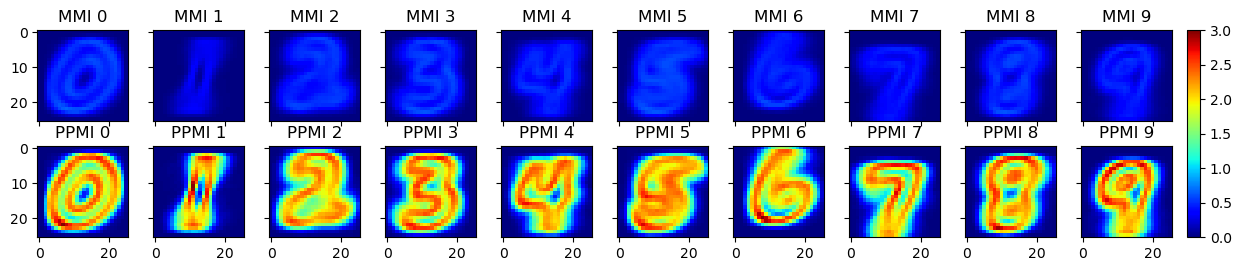

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(15, 10))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,10),
                 axes_pad=0.25,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
for i, ax in enumerate(grid):
    if i < 10:
        mean_MI = MI_matrices[i].mean(axis=0).reshape([26, 26])
        im = ax.imshow(mean_MI, vmin=0, vmax=3, cmap='jet')
        ax.set_title('MMI ' + str(i))
    else:
        PPMI = PPMI_matrices[i-10]
        im = ax.imshow(PPMI, vmin=0, vmax=3, cmap='jet')
        ax.set_title('PPMI ' + str(i-10))
    
# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

We see some similar trends in that the mean MI (MMI) between pixels of filter 0 with filter 1 are weaker than paired pixel MI (PPMI).

The most intense MI occurs near the "outlines" of the numbers, which suggests one filter and another filter are strongly related at the same pixels near the most common areas for outlines of the digits. This makes sense given that we have observed the filters pick up strongly on these regions.

It is interesting to note certain pixels in the most central regions of the numbers have low MI (e.g. blue regions in the center of 1, 3, 4, 6, 8, and 9--and light green portions within the 0, 2, and 7). This needs more study, but it makes sense since the filters are less frequently activated away from the edges.

### Class-Specific MI for Pairs of Filters

In [ ]:
MI_class_matrices = []

for k in range(16):
    for l in range(k+1):
        print('\n=============================== Computing filter-level MI matrices for filters', k, 'and', l, '===============================\n')
        MI_class_matrices_kl = compute_MI_matrix_classes((k, l, test_activation, testY_int))
        MI_class_matrices.append(MI_class_matrices_kl)


=============================== Computing filter-level MI matrices for filters 0 and 0 ===============================

Finished with MI matrix for class 0 in 20.89 seconds
Finished with MI matrix for class 1 in 21.62 seconds
Finished with MI matrix for class 2 in 21.18 seconds
Finished with MI matrix for class 3 in 21.56 seconds
Finished with MI matrix for class 4 in 21.09 seconds
Finished with MI matrix for class 5 in 19.70 seconds
Finished with MI matrix for class 6 in 19.94 seconds
Finished with MI matrix for class 7 in 21.61 seconds
Finished with MI matrix for class 8 in 21.16 seconds
Finished with MI matrix for class 9 in 20.60 seconds

=============================== Computing filter-level MI matrices for filters 1 and 0 ===============================

Finished with MI matrix for class 0 in 20.37 seconds
Finished with MI matrix for class 1 in 21.03 seconds
Finished with MI matrix for class 2 in 20.79 seconds
Finished with MI matrix for class 3 in 20.67 seconds
Finished with MI

In [ ]:
import pickle as pkl

In [ ]:
#with open('MI_class_matrices.pkl', 'wb') as f:
#    pkl.dump(MI_class_matrices, f) 

## Analysis of Class-Specific Filter MIs

In [ ]:
import pickle as pkl

with open('../MI_class_matrices.pkl', 'rb') as f:
    MI_class_matrices = pkl.load(f)

In [ ]:
PPMI_class_matrices = []
j = 0

for k in range(16):
    PPMI_k = []
    
    for l in range(k+1):
        PPMI_kl = []
        
        for c in range(10):
            PPMI_kl_class = []
            PPMI_kl_class.append(np.diag(MI_class_matrices[j][c]))
            #for i in range(676):
                # MI_class_matrices[j][c] is MI matrix for filter pair number j, class number c
            #    PPMI_kl_class.append(MI_class_matrices[j][c][i,i])

            PPMI_kl_class = np.array(PPMI_kl_class).reshape([26,26])
            PPMI_kl.append(PPMI_kl_class)
            
        PPMI_k.append(PPMI_kl)
        j += 1
        
    PPMI_class_matrices.append(PPMI_k)

In [ ]:
# PPMI_class_matrices are the paired pixel MIs for each pair of filters and each class
#
# PPMI_class_matrices[i][j][k] will give you the paired-pixel MI matrices for
#
#     filter i (i must be >= j)
#     filter j
#     class k

PPMI_class_matrices[6][5][0].shape

(26, 26)

### Plotting

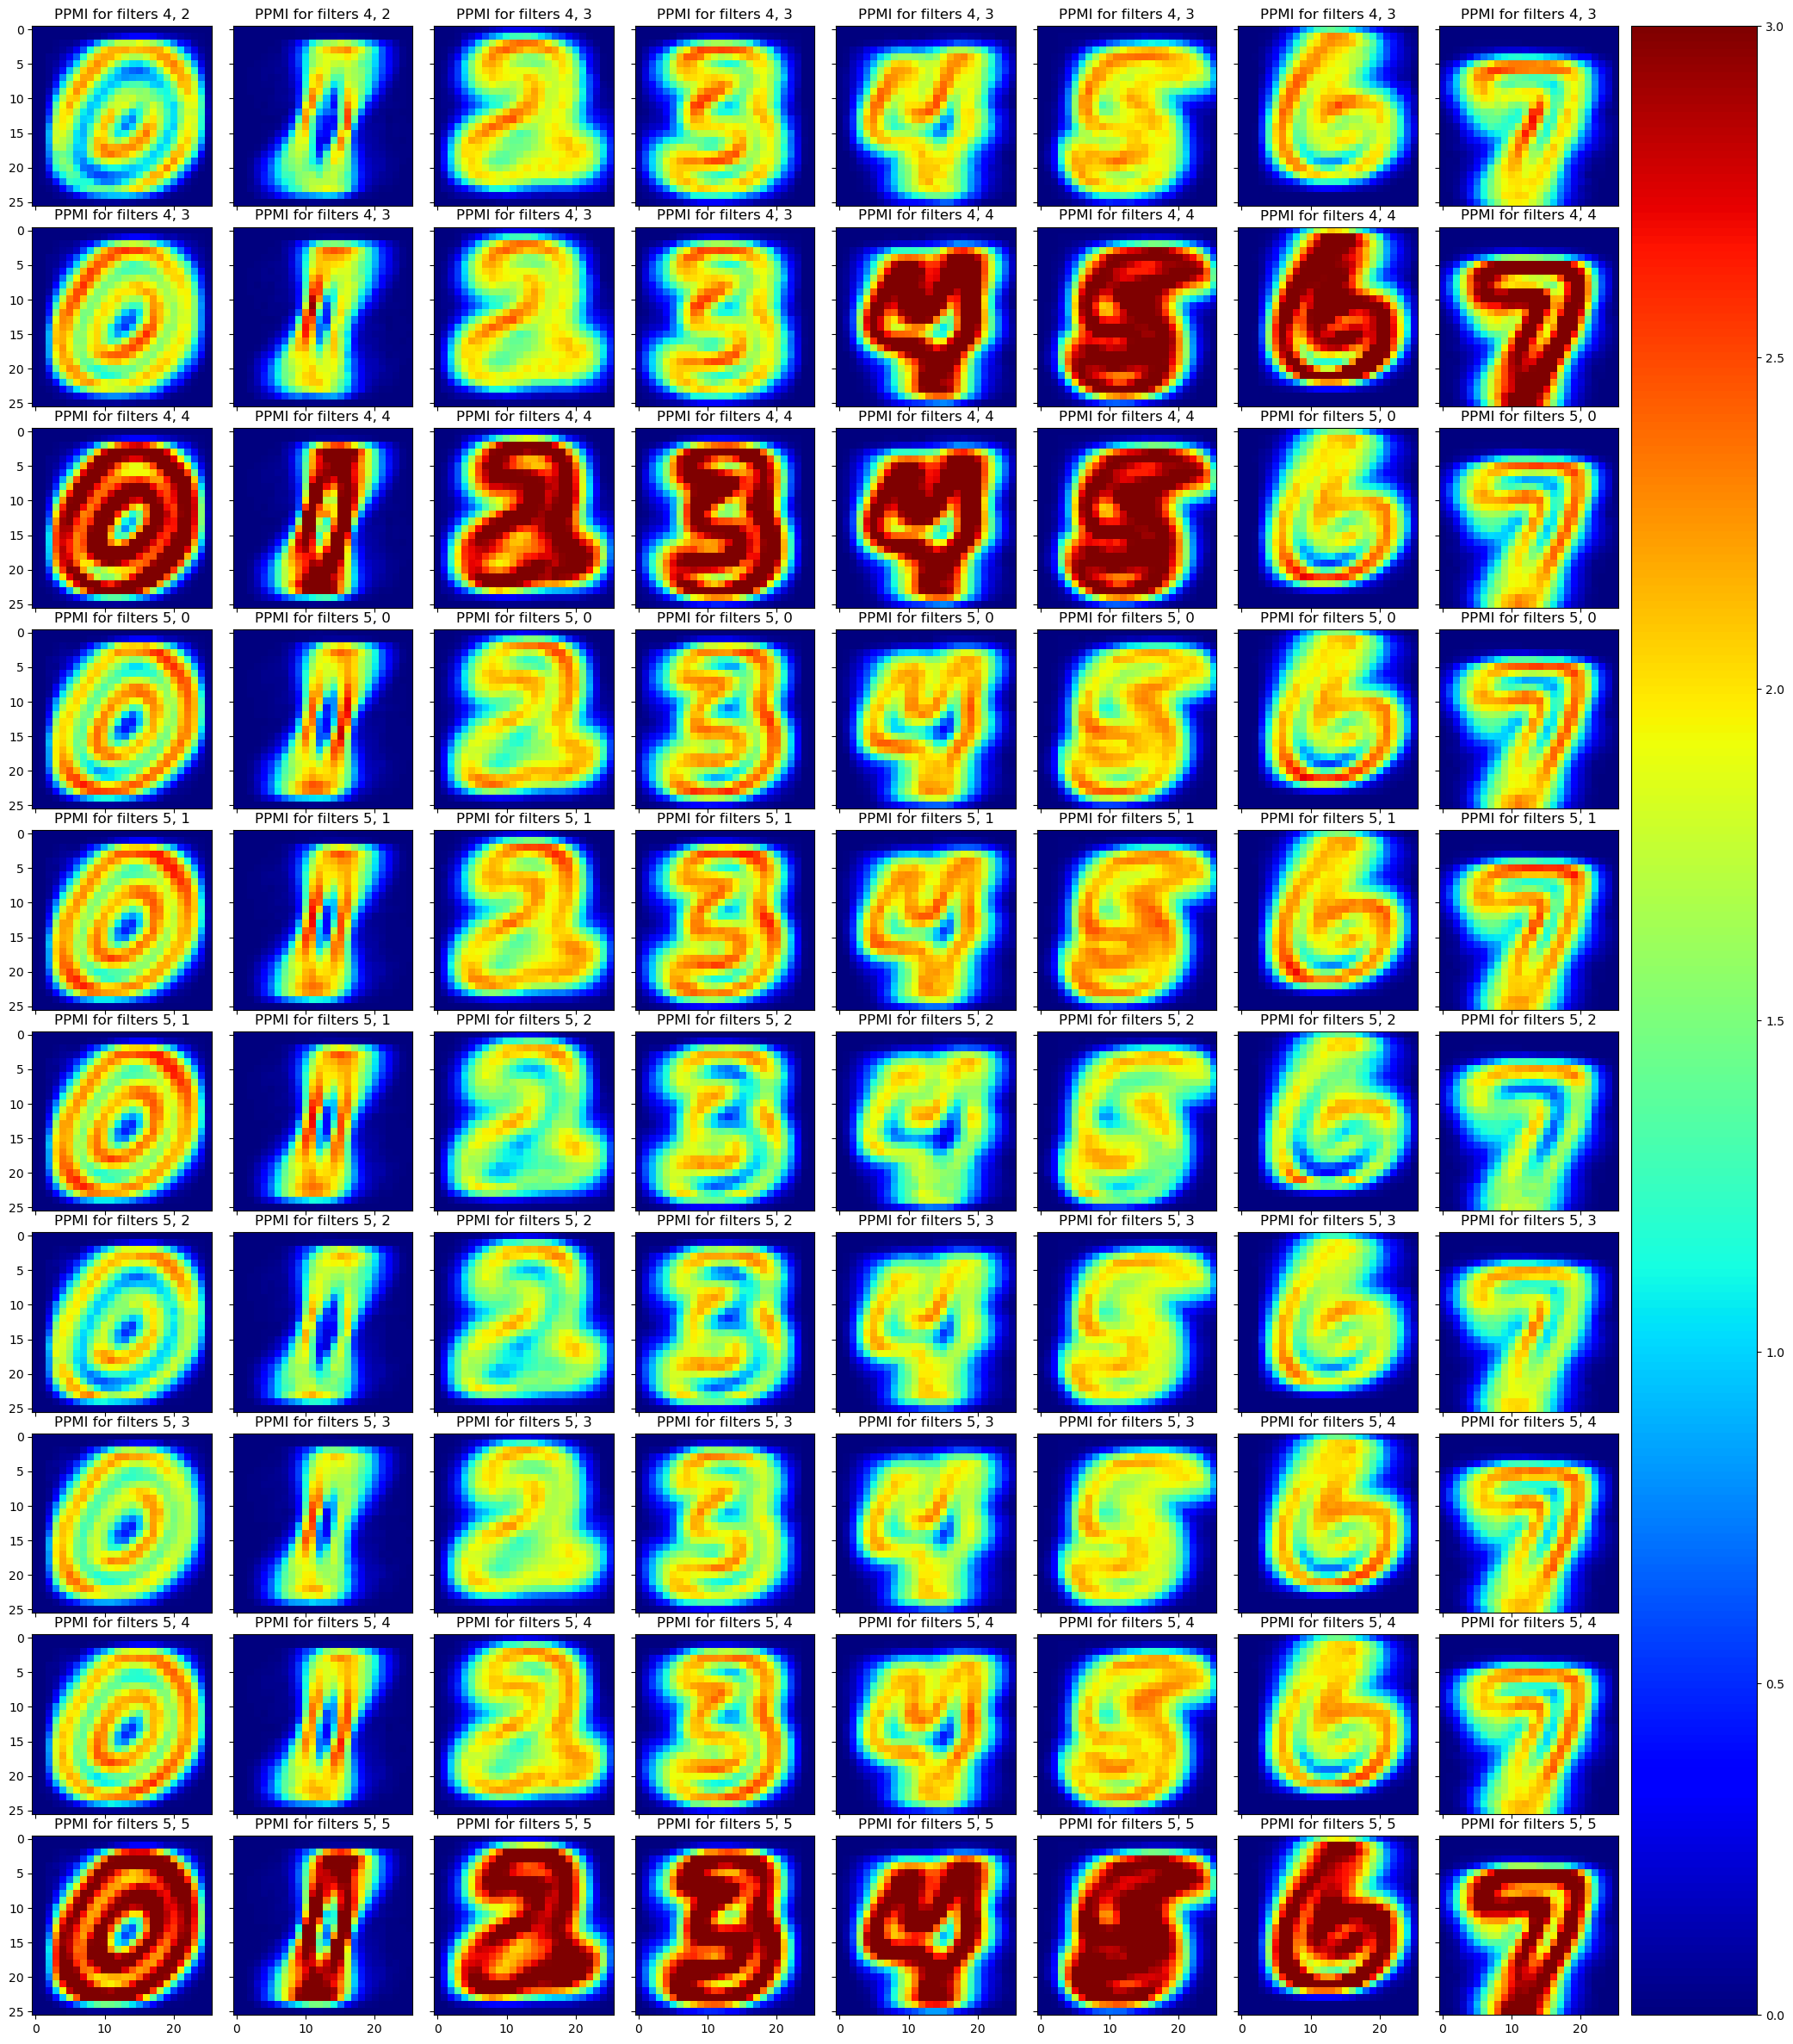

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
factor = 0
# Set up figure and image grid
fig = plt.figure(figsize=(75, 30))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(8,10),
                 axes_pad=0.25,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# record the filter numbers (0-15, 0-15) for each pair of filters (0-135)
filter_indices = []
for k in range(16):
    for l in range(k+1):
        filter_indices.append([k, l])

# Add data to image grid
for i, ax in enumerate(grid, factor*grid._ncols):
    # find the row of the plot (i.e. the filter pair number)
    j = i // grid._nrows
    
    # find the column of the plot (i.e. the class number)
    c = i % grid._ncols
    
    # find the filter numbers for filter pair j
    filters = filter_indices[j]
    
    # grab the PPMI for the current pair of filters and class
    PPMI = PPMI_class_matrices[filters[0]][filters[1]][c]
    
    # plot the PPMI matrix
    im = ax.imshow(PPMI, vmin=0, vmax=3, cmap='jet')
    ax.set_title('PPMI for filters ' + str(filters[0]) + ', ' + str(filters[1]))
    
# add a colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_PPMIs(factor, max_rows = 10):
    # Set up figure and image grid
    fig = plt.figure(figsize=(30, 30))

    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(max_rows, 10),
                     axes_pad=0.25,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )

    # record the filter numbers (0-15, 0-15) for each pair of filters (0-135)
    filter_indices = []
    for k in range(16):
        for l in range(k+1):
            filter_indices.append([k, l])

    starter = filter_indices[factor]
    # Add data to image grid
    for i, ax in enumerate(grid, factor*grid._ncols):
        # find the row of the plot (i.e. the filter pair number)
        j = i // 10

        # find the column of the plot (i.e. the class number)
        c = i % grid._ncols

        # find the filter numbers for filter pair j
        filters = filter_indices[j]
        #print(filters)

        # grab the PPMI for the current pair of filters and class
        PPMI = PPMI_class_matrices[filters[0]][filters[1]][c]

        # plot the PPMI matrix
        im = ax.imshow(PPMI, vmin=0, vmax=3, cmap='jet')
        ax.set_title('PPMI for filters ' + str(filters[0]) + ', ' + str(filters[1]))

    # add a colorbar
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)

    #plt.show()
    
    plt.savefig('PPMIs_starting_at_filters_' + str(starter))

Exporting figure 0
Exporting figure 1
Exporting figure 2
Exporting figure 3
Exporting figure 4
Exporting figure 5
Exporting figure 6
Exporting figure 7
Exporting figure 8
Exporting figure 9
Exporting figure 10
Exporting figure 11
Exporting figure 12
Exporting figure 13


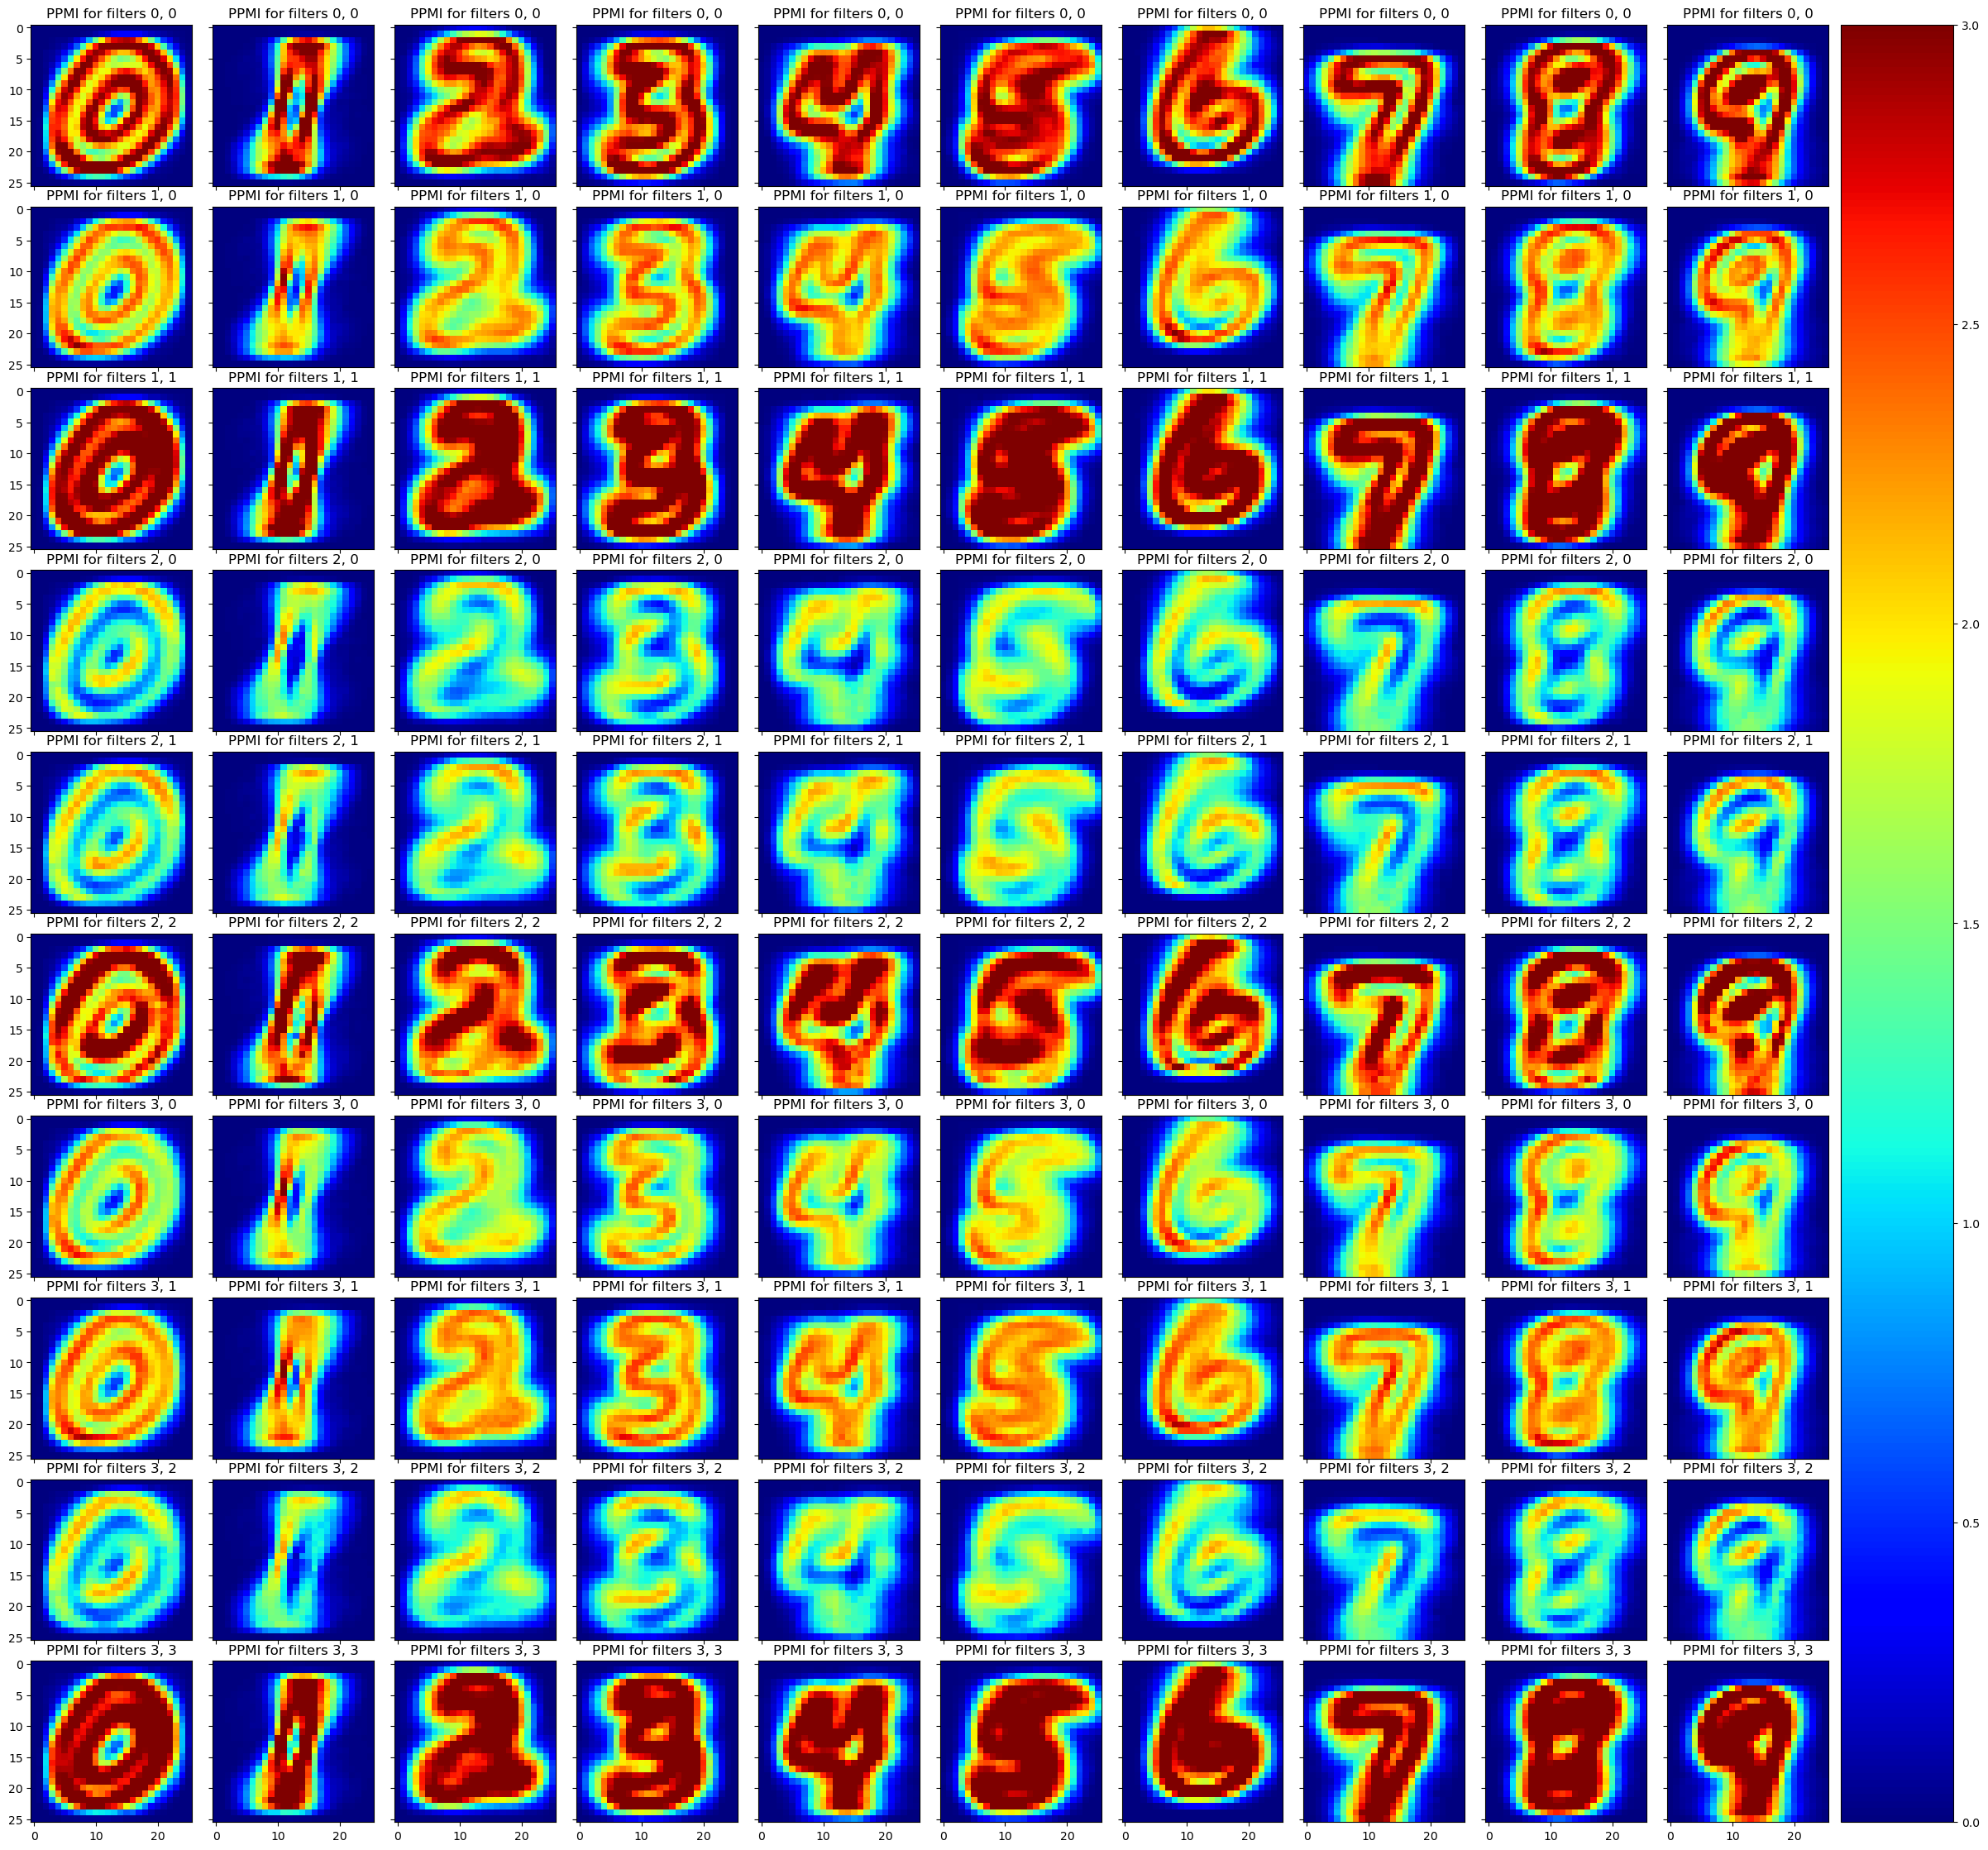

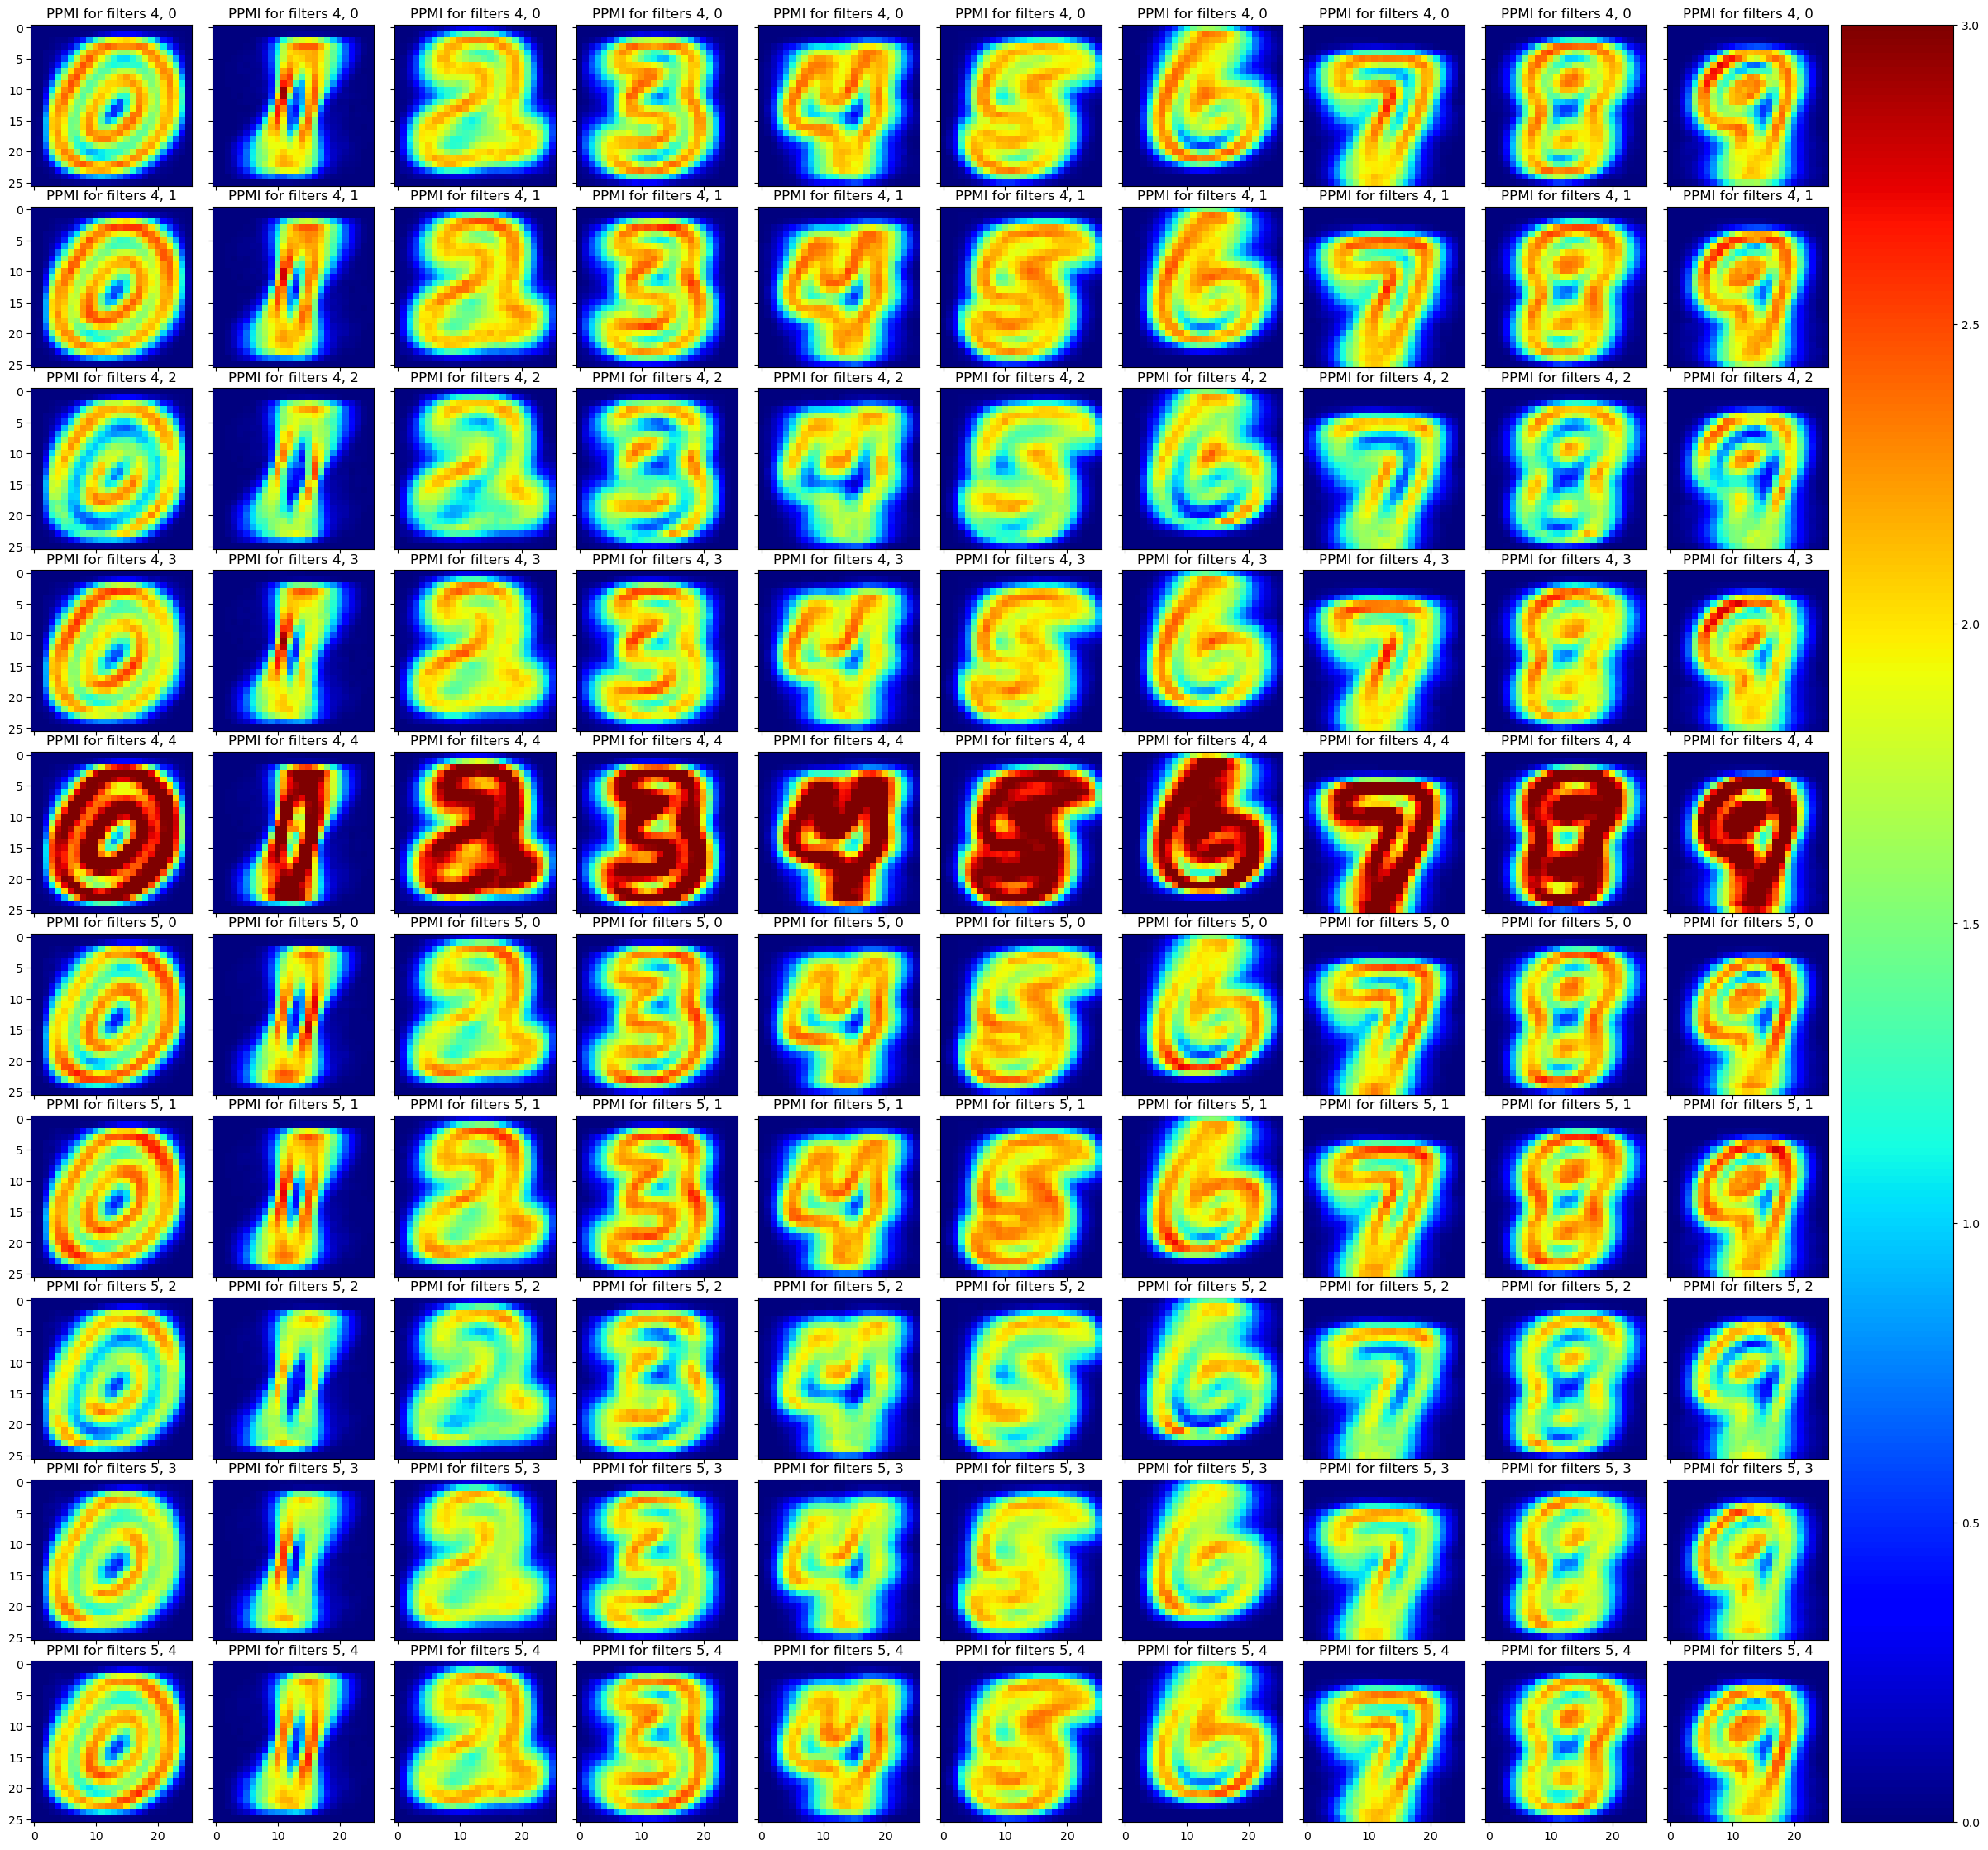

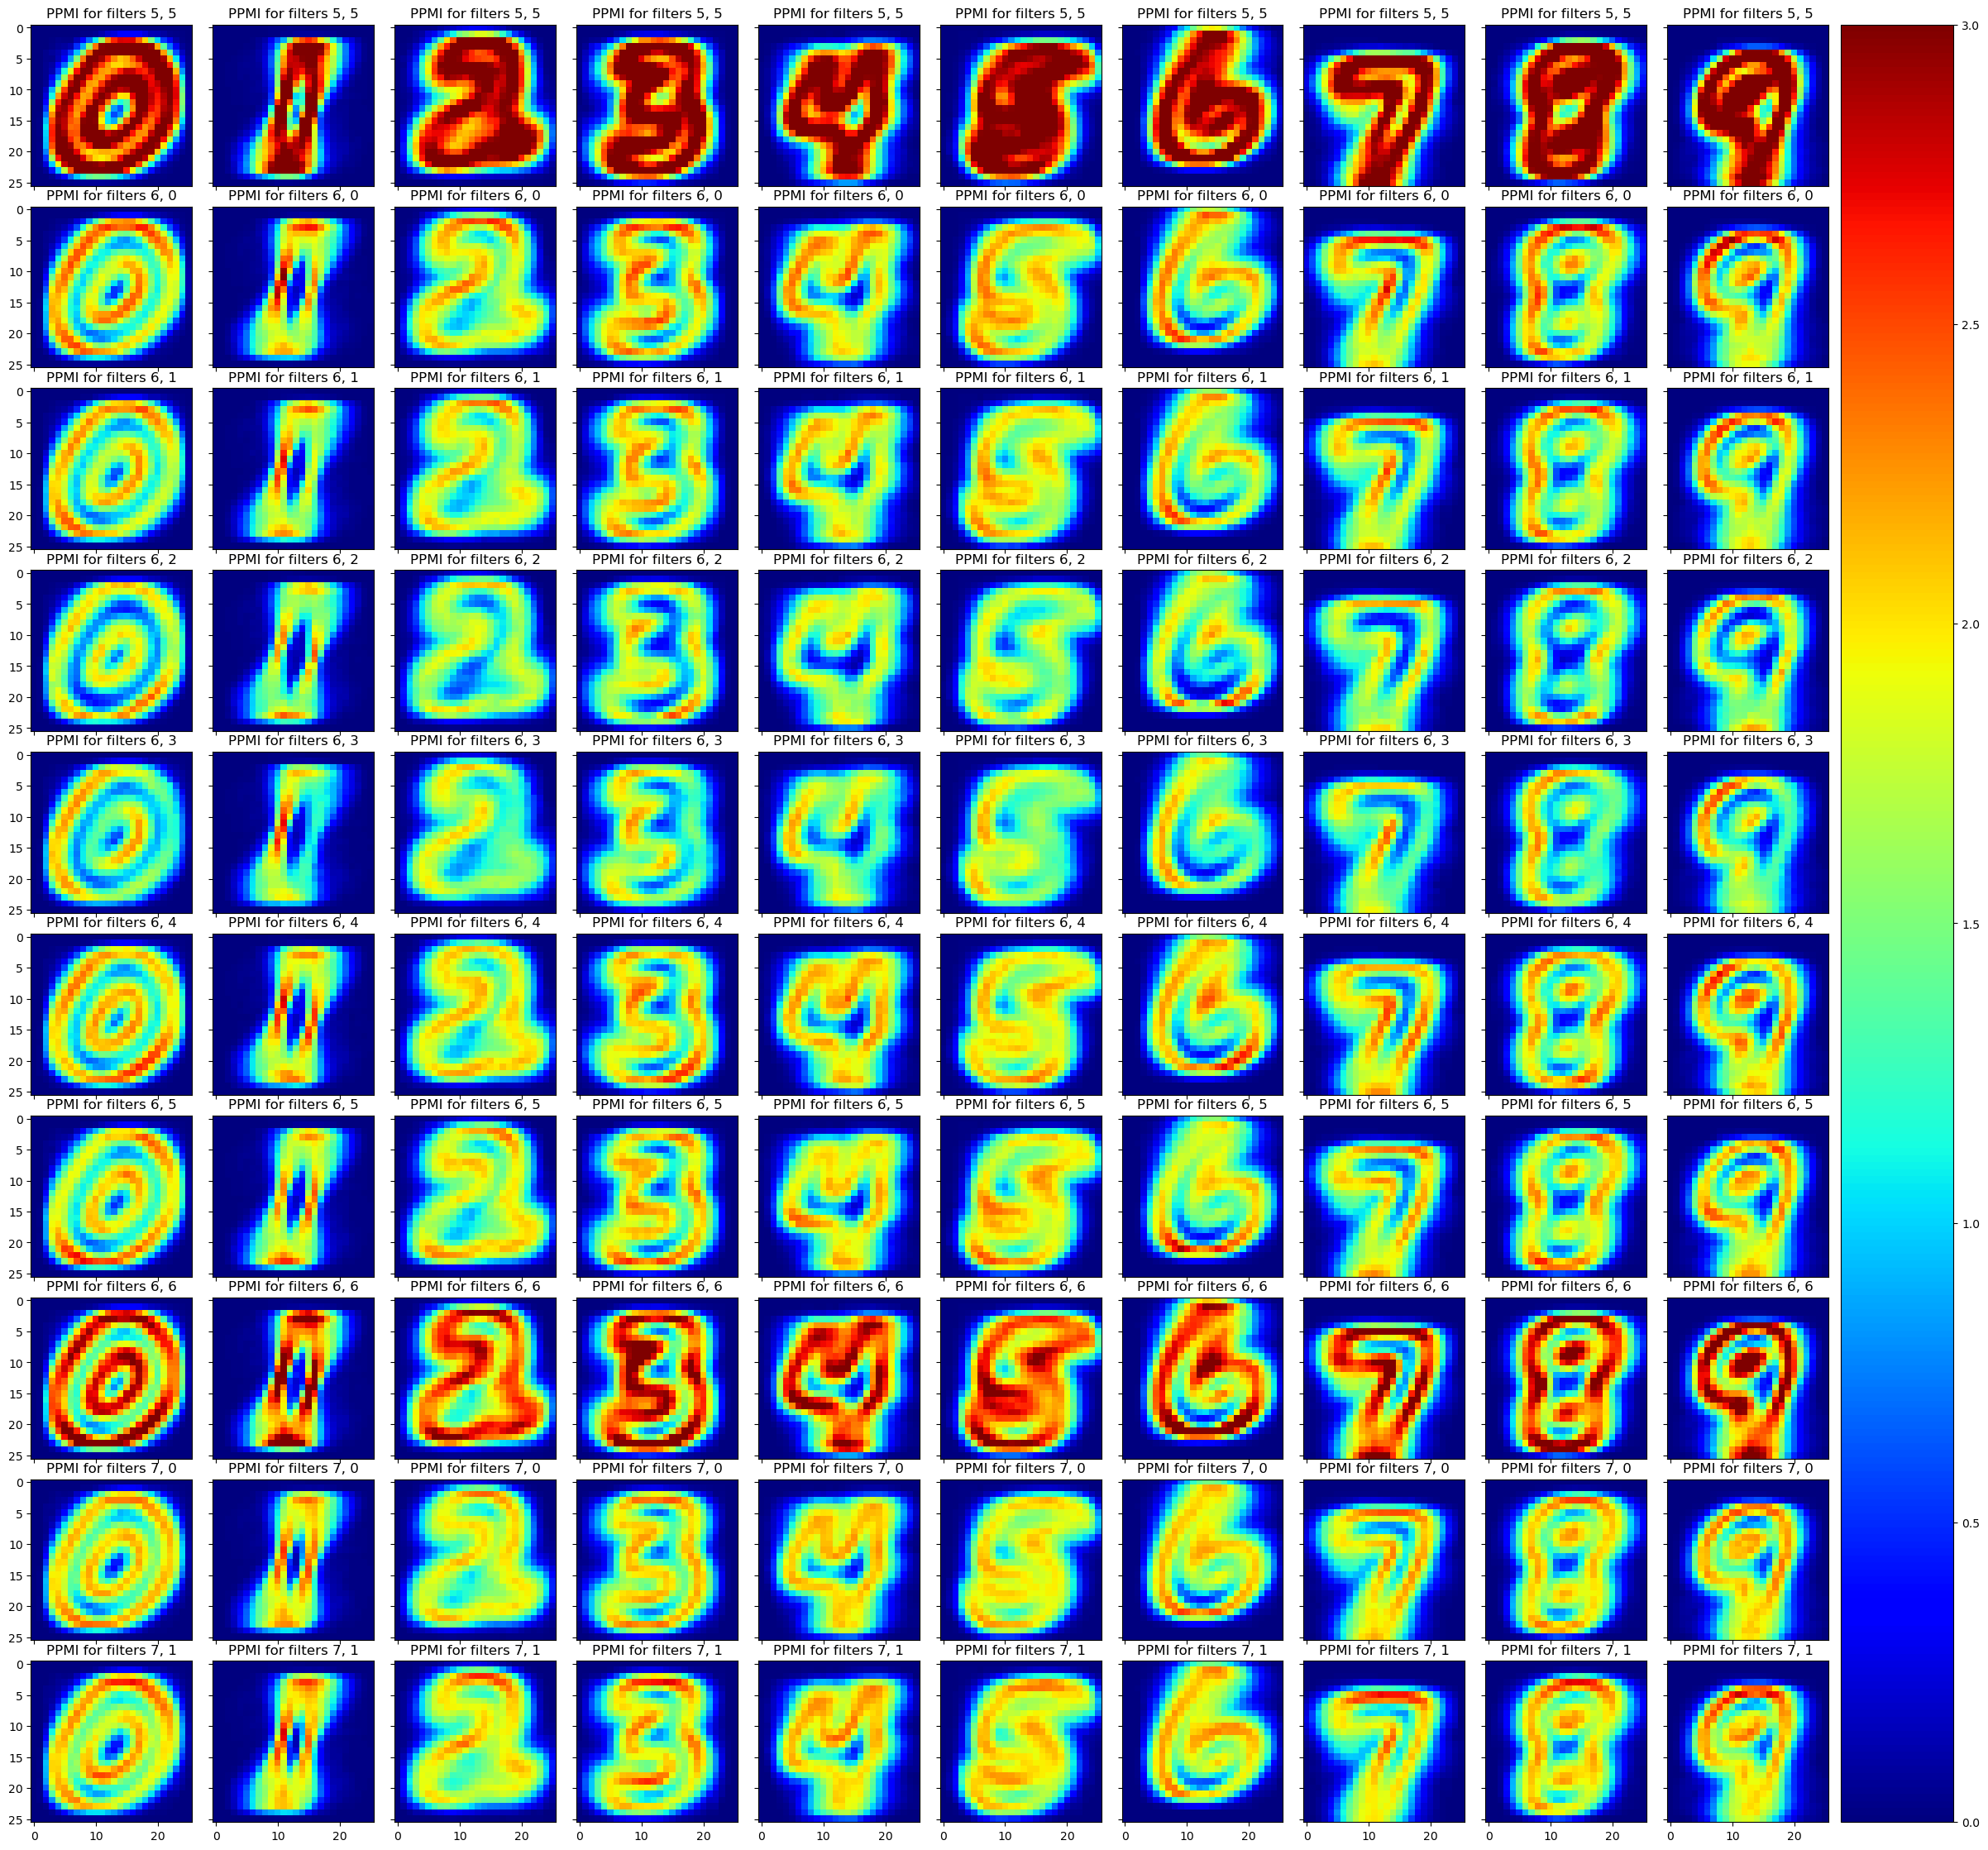

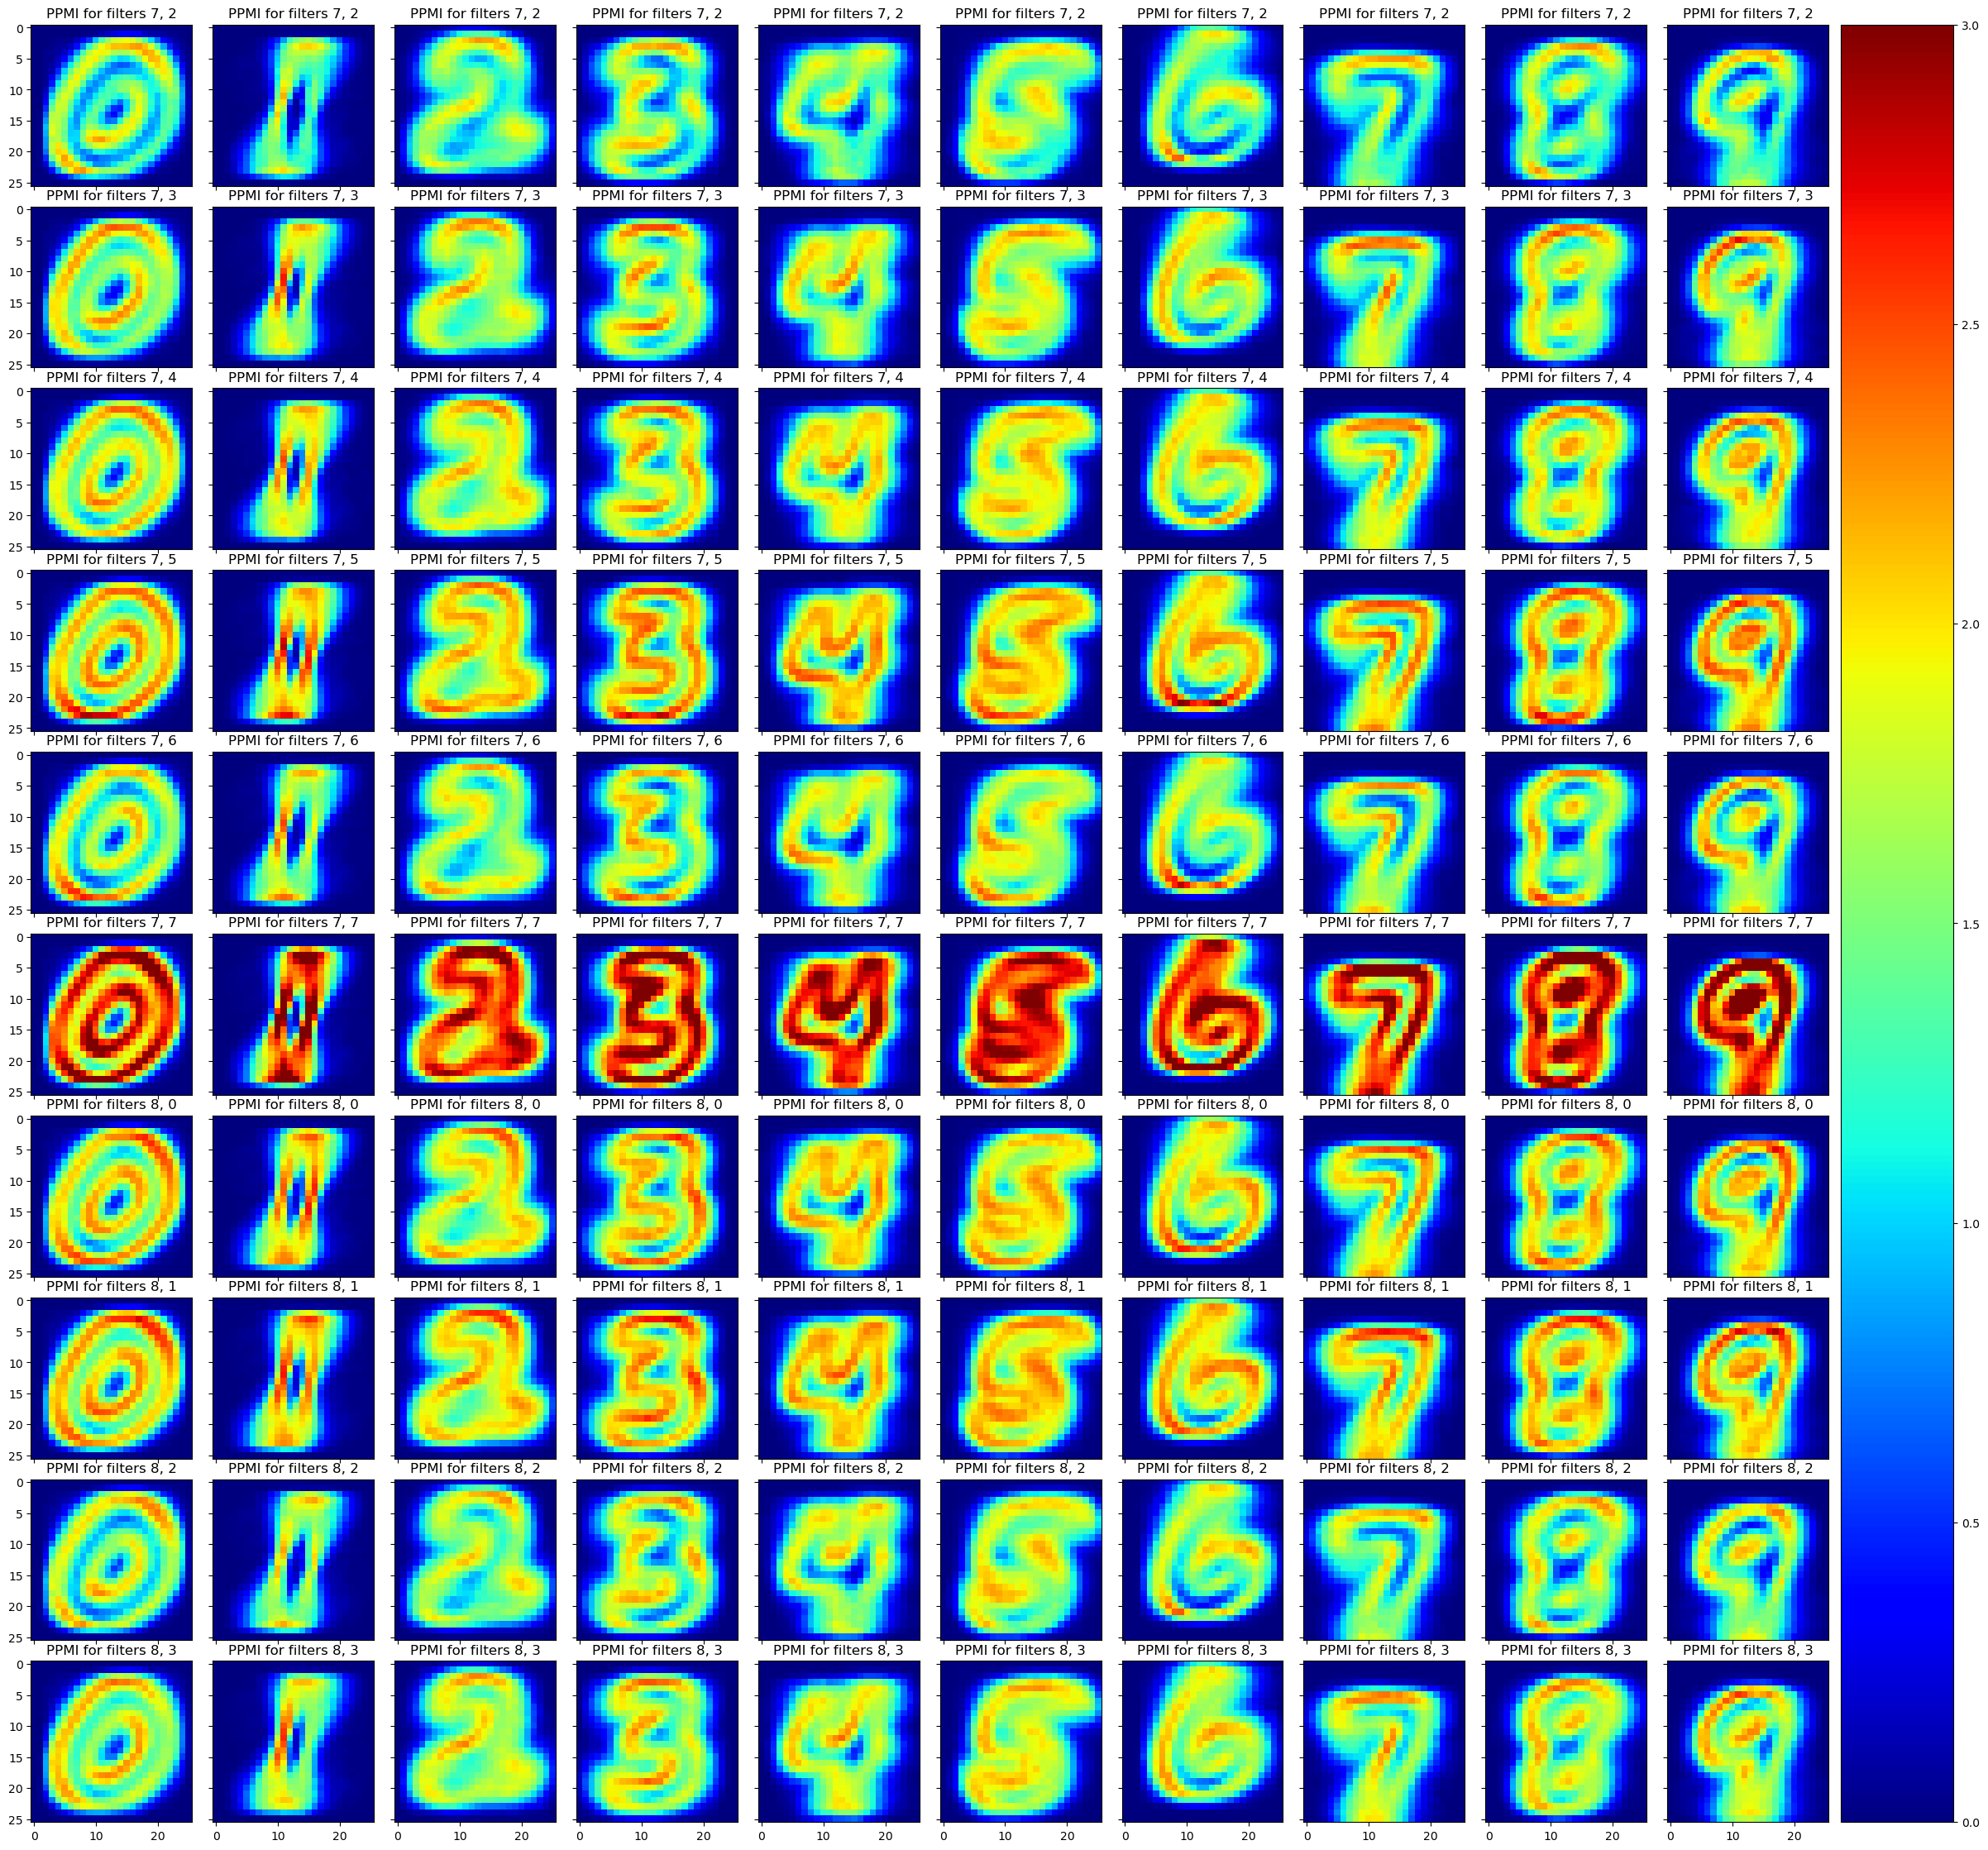

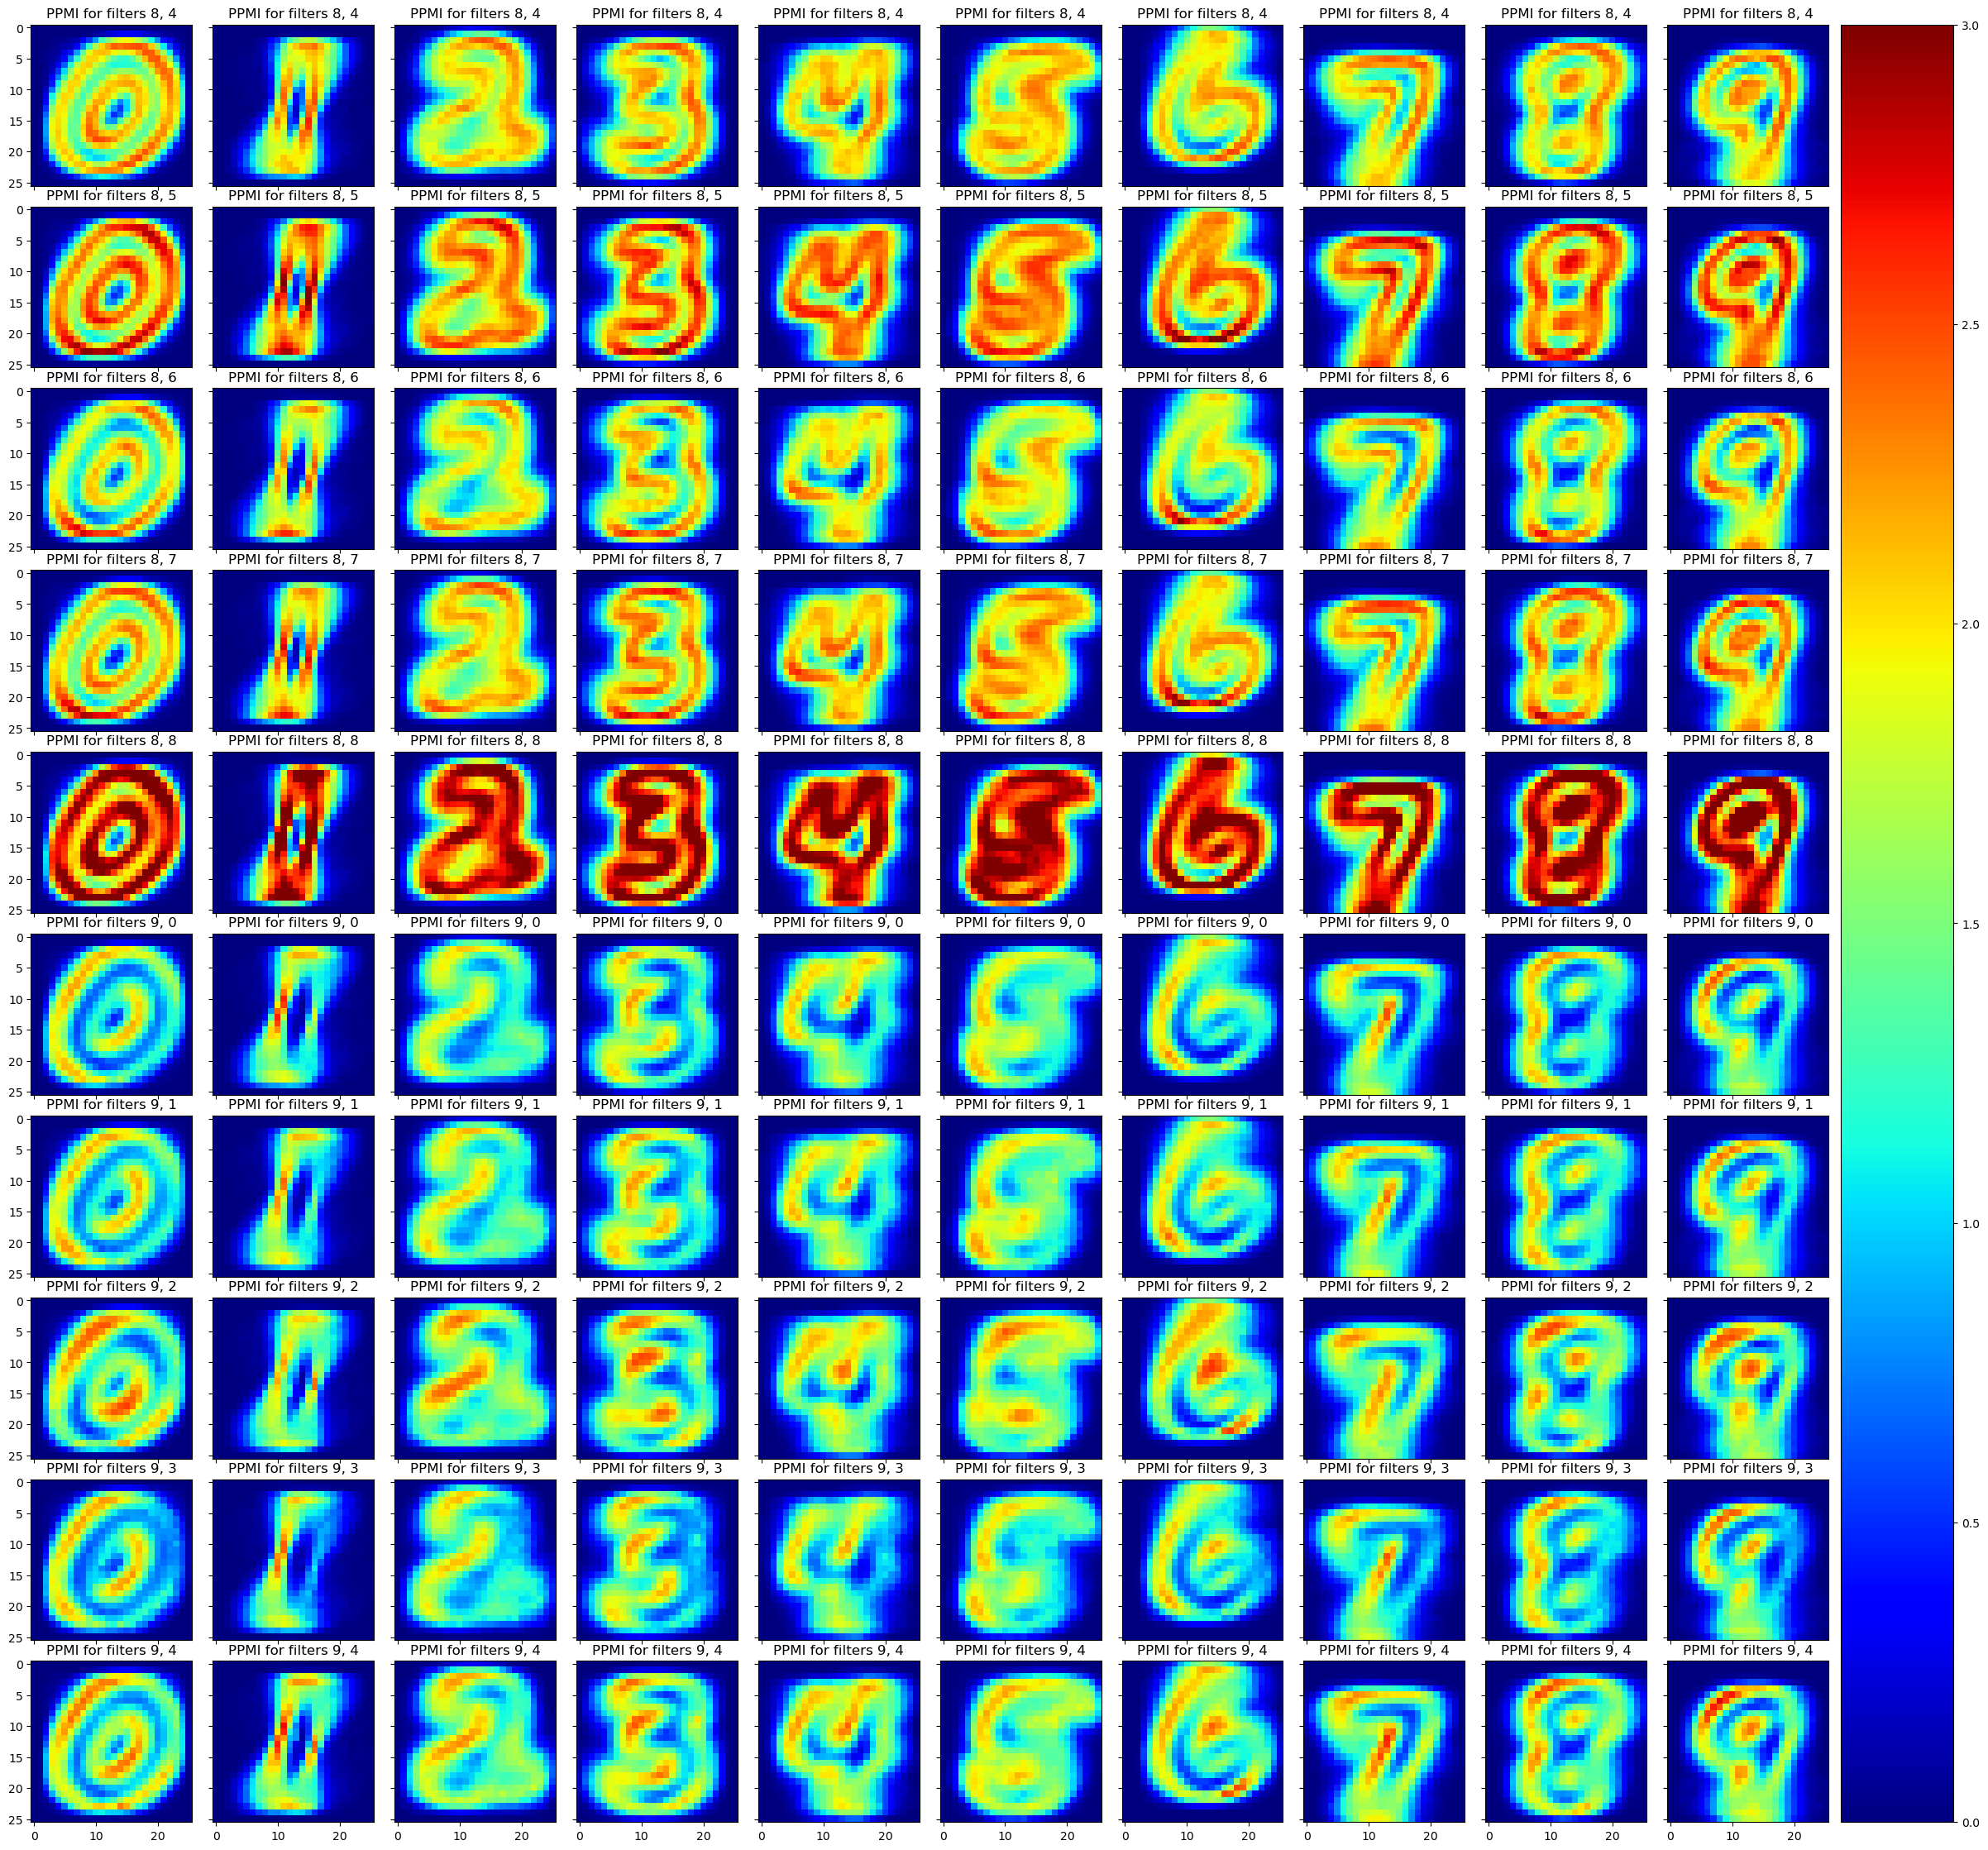

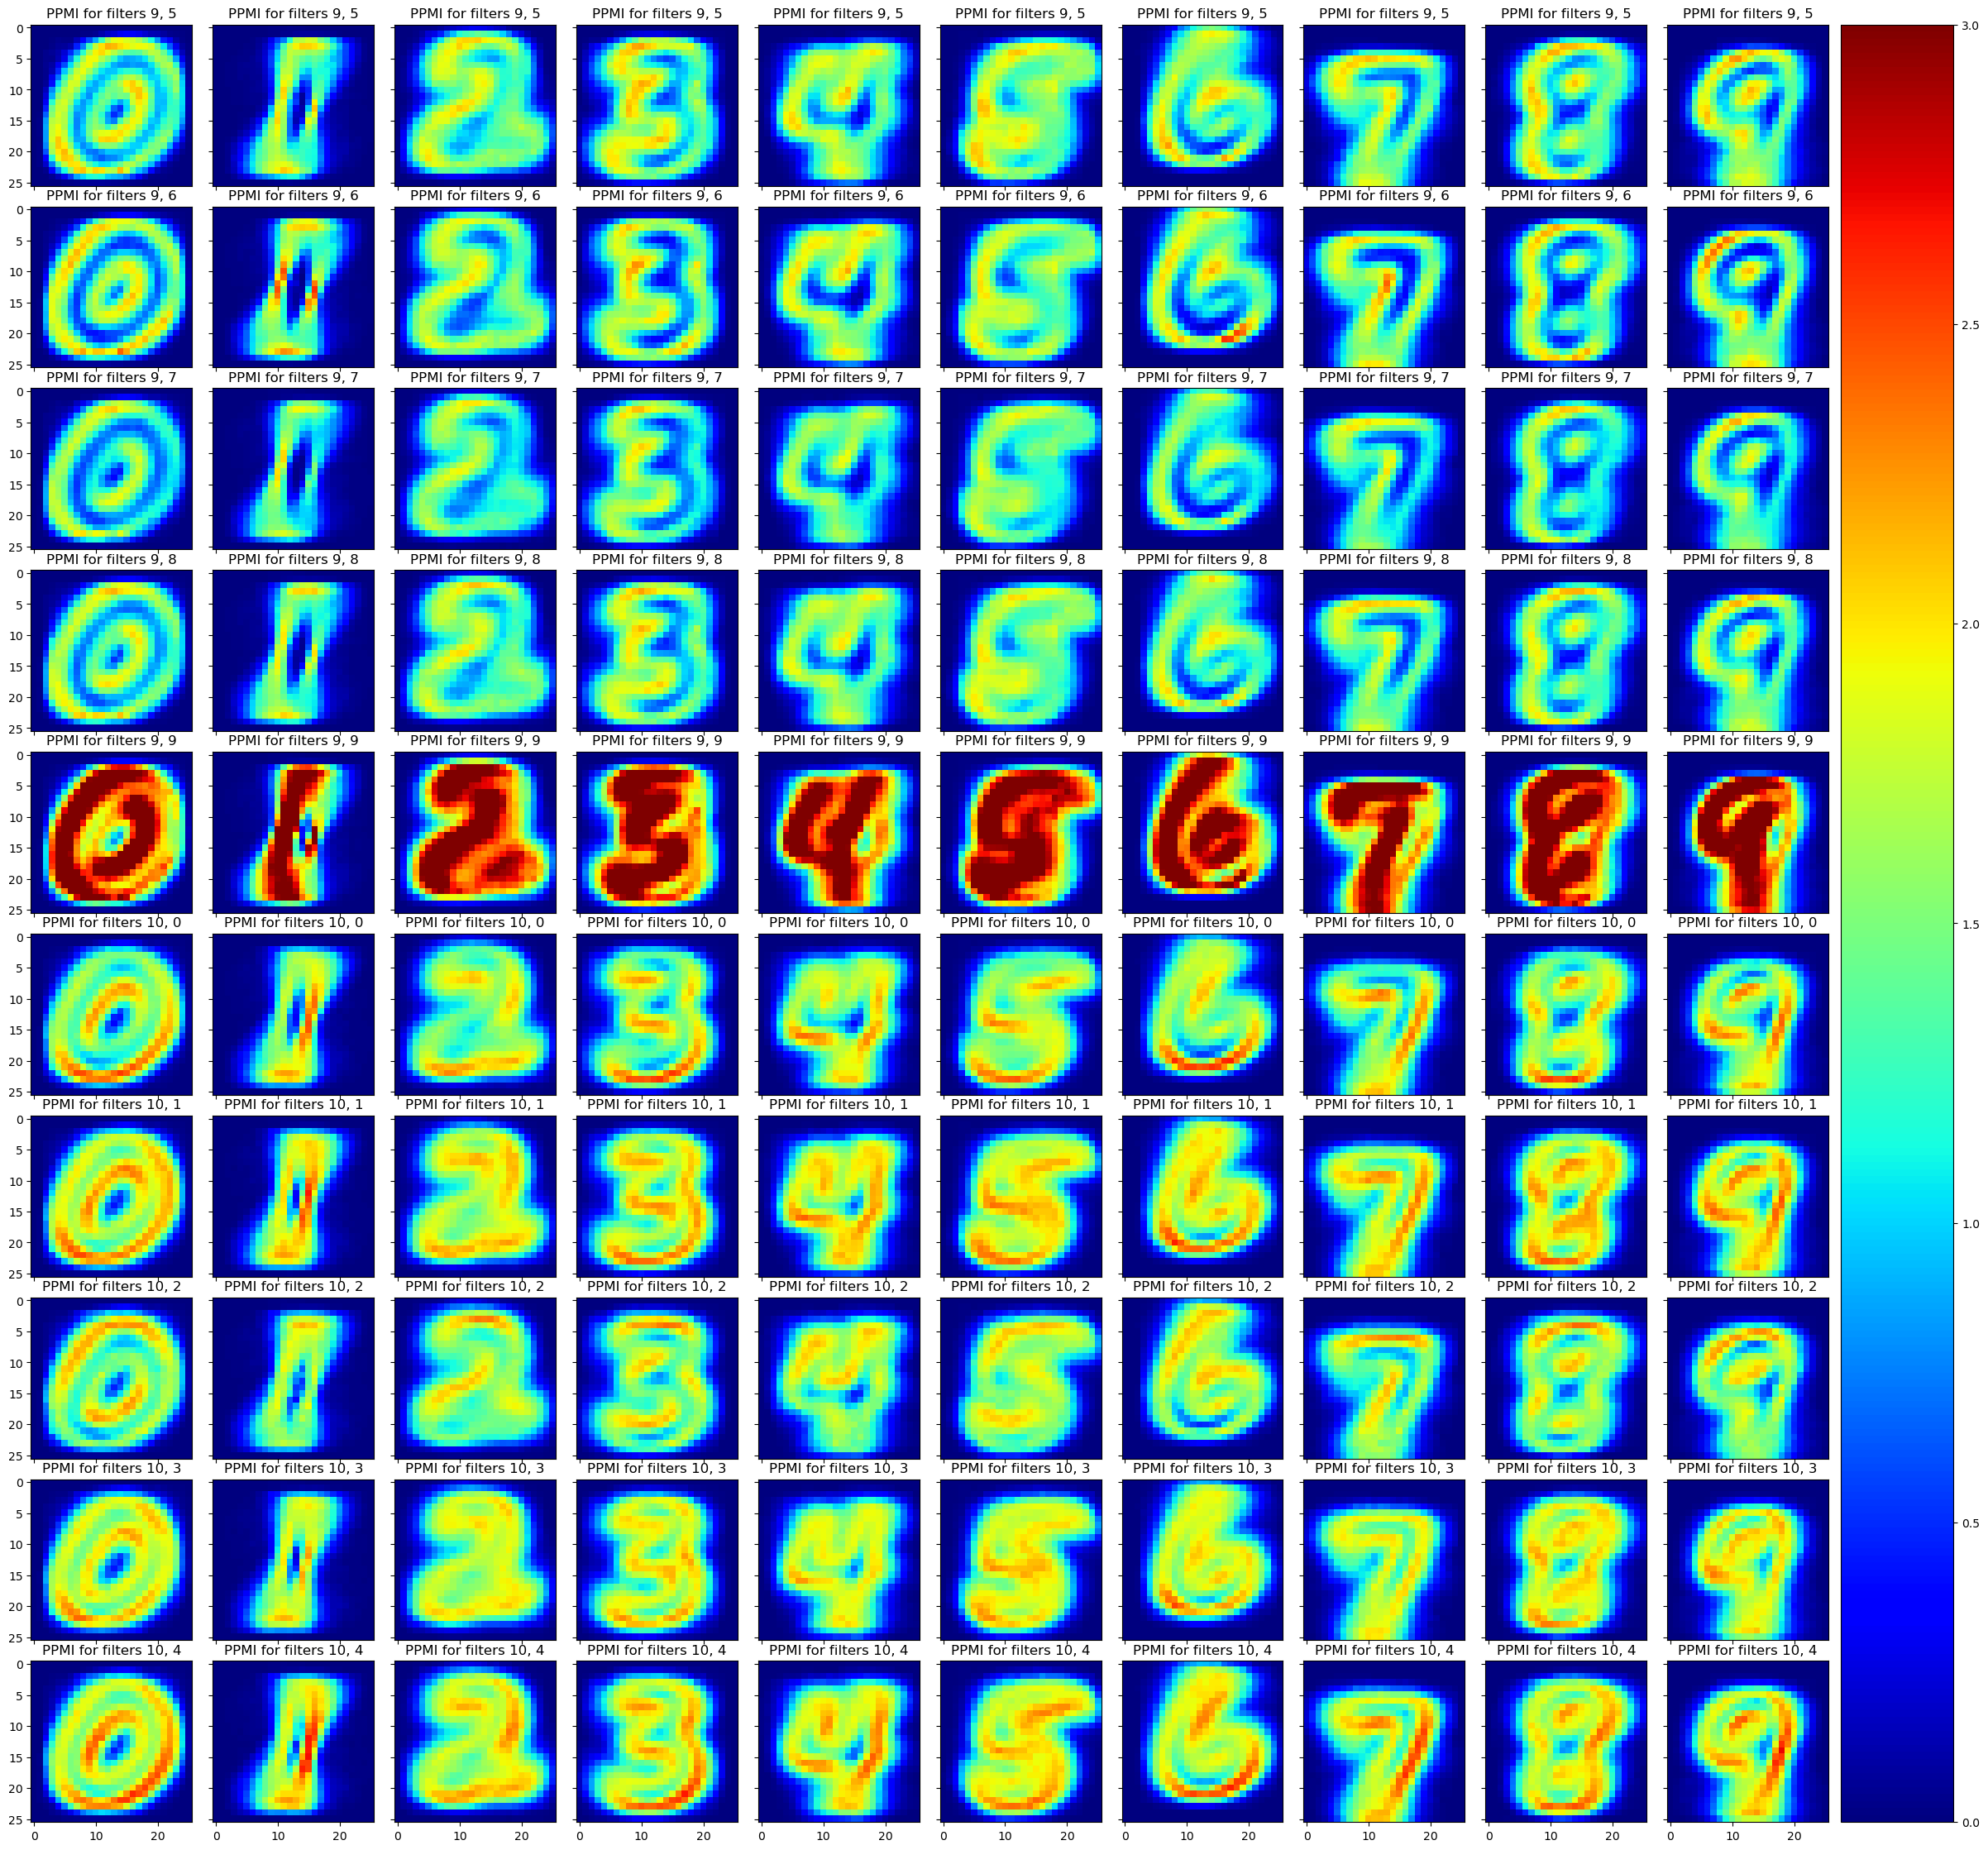

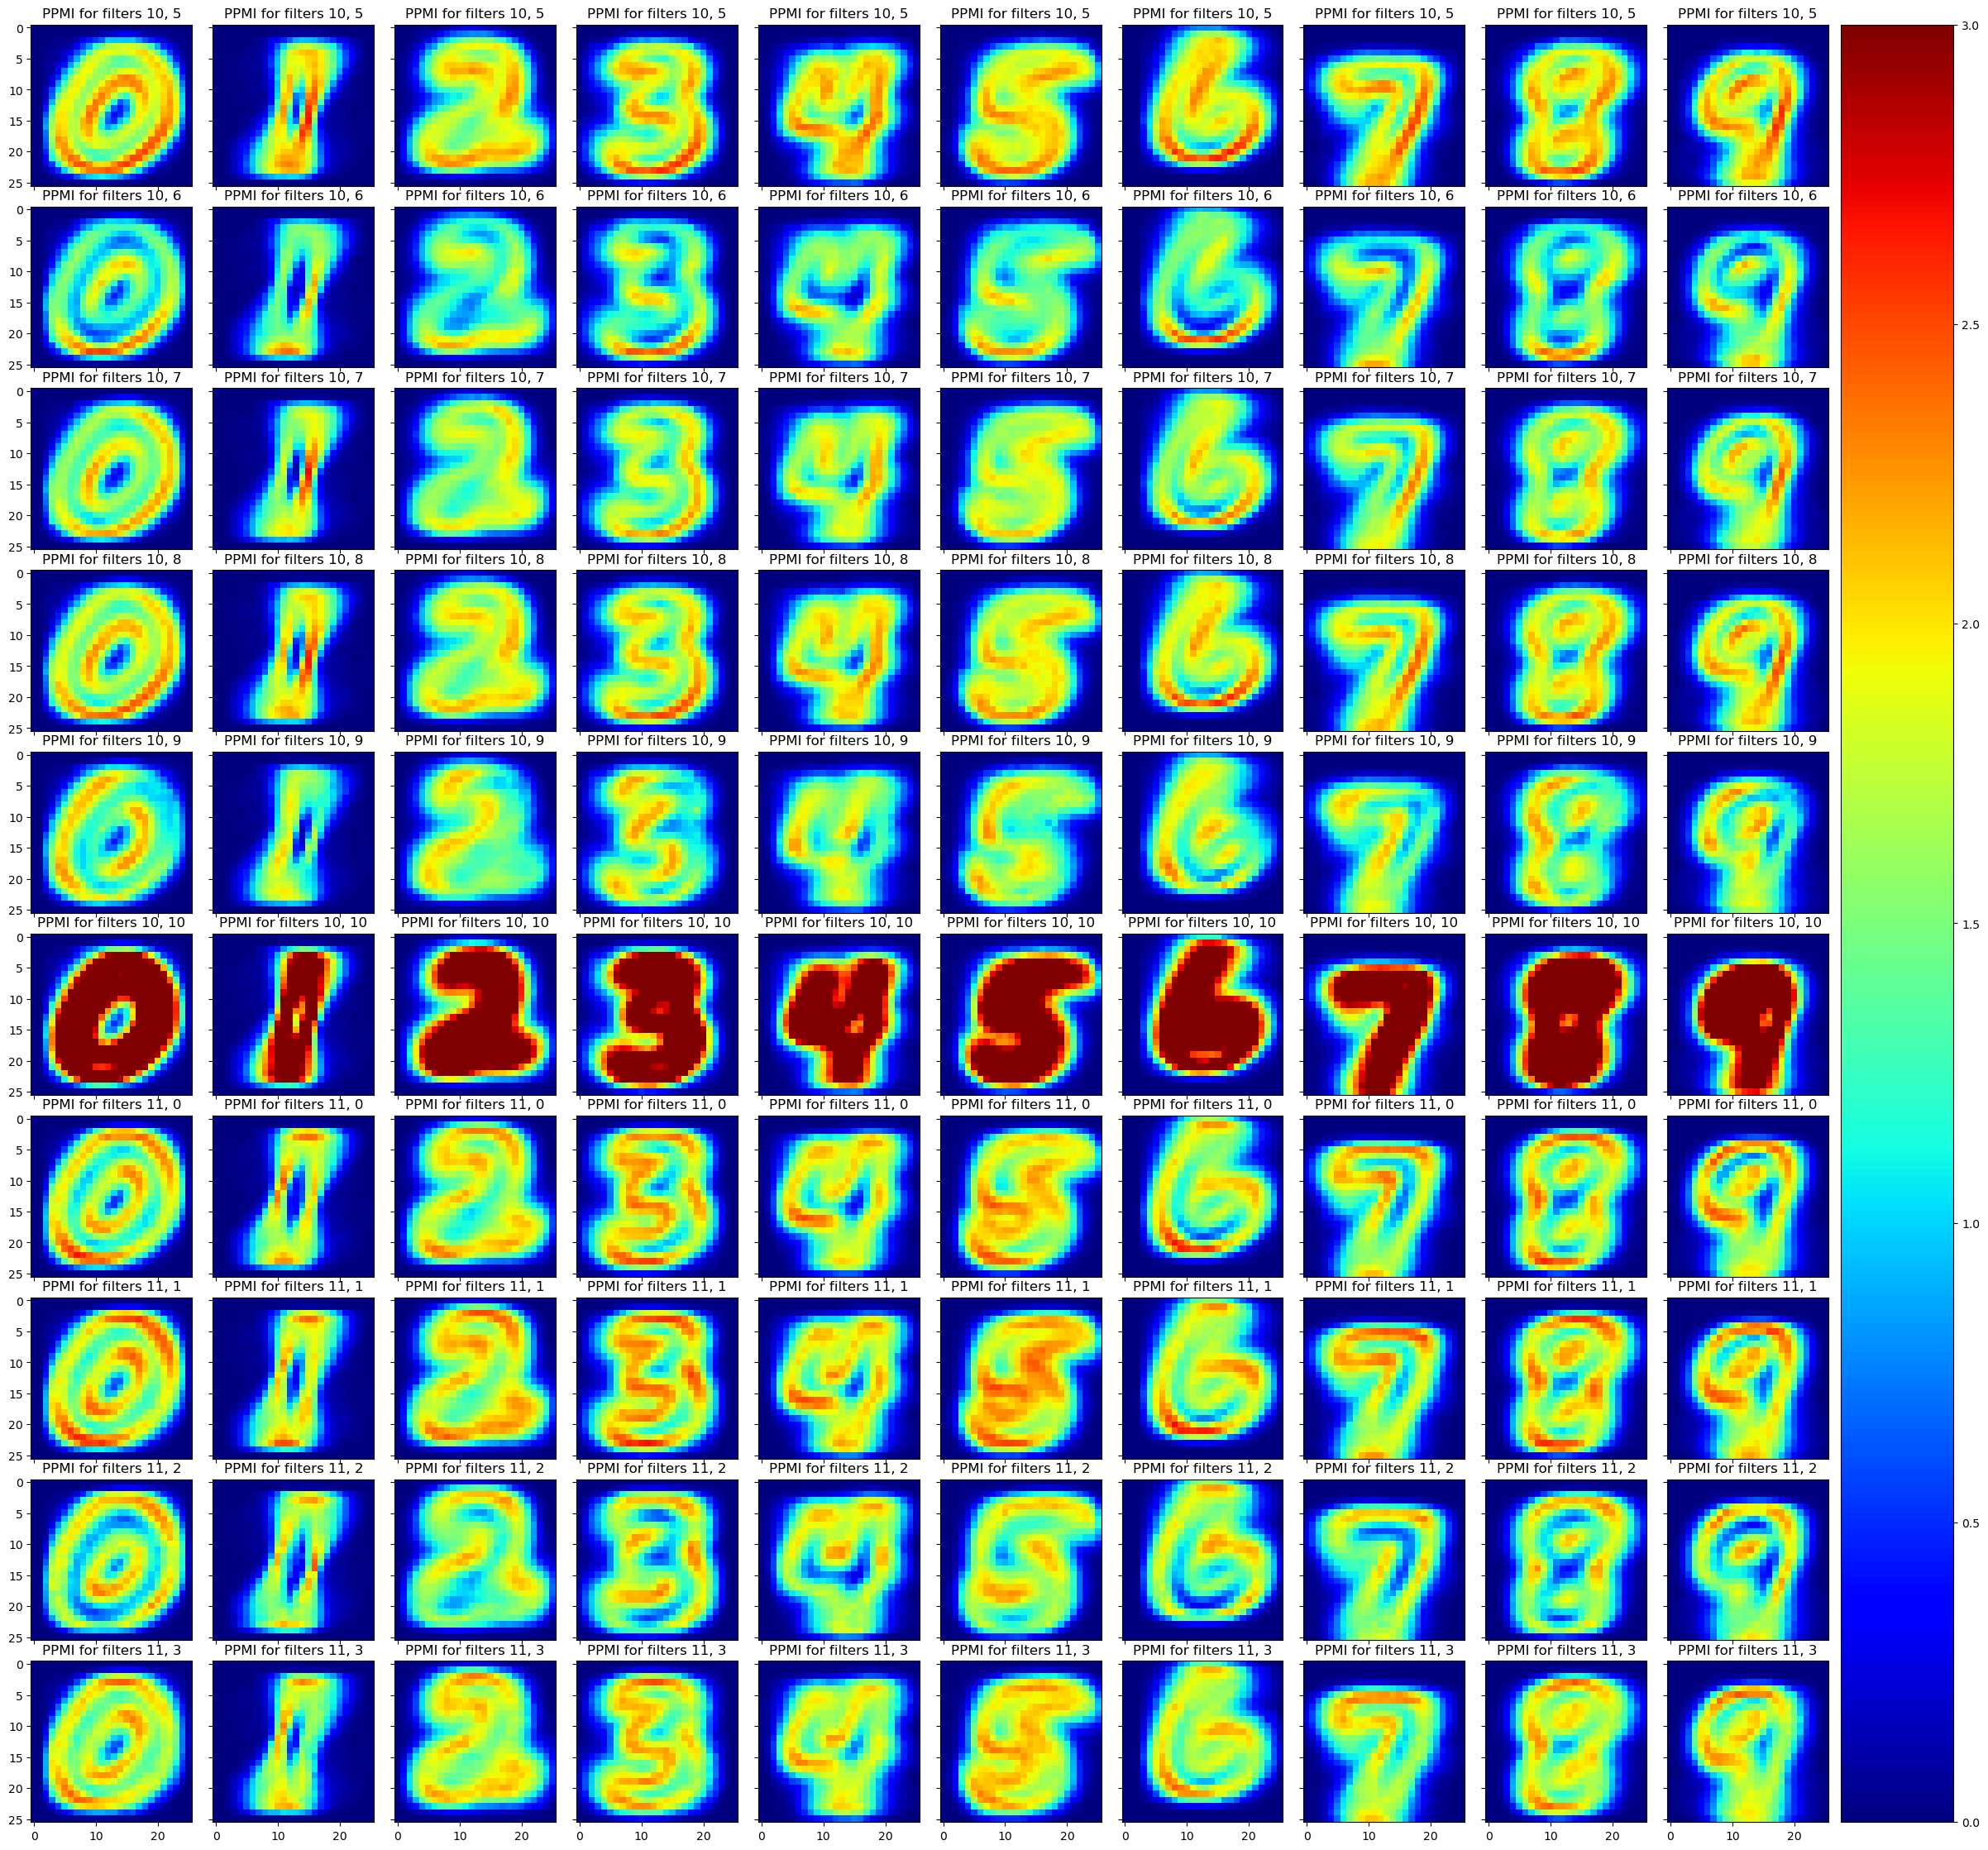

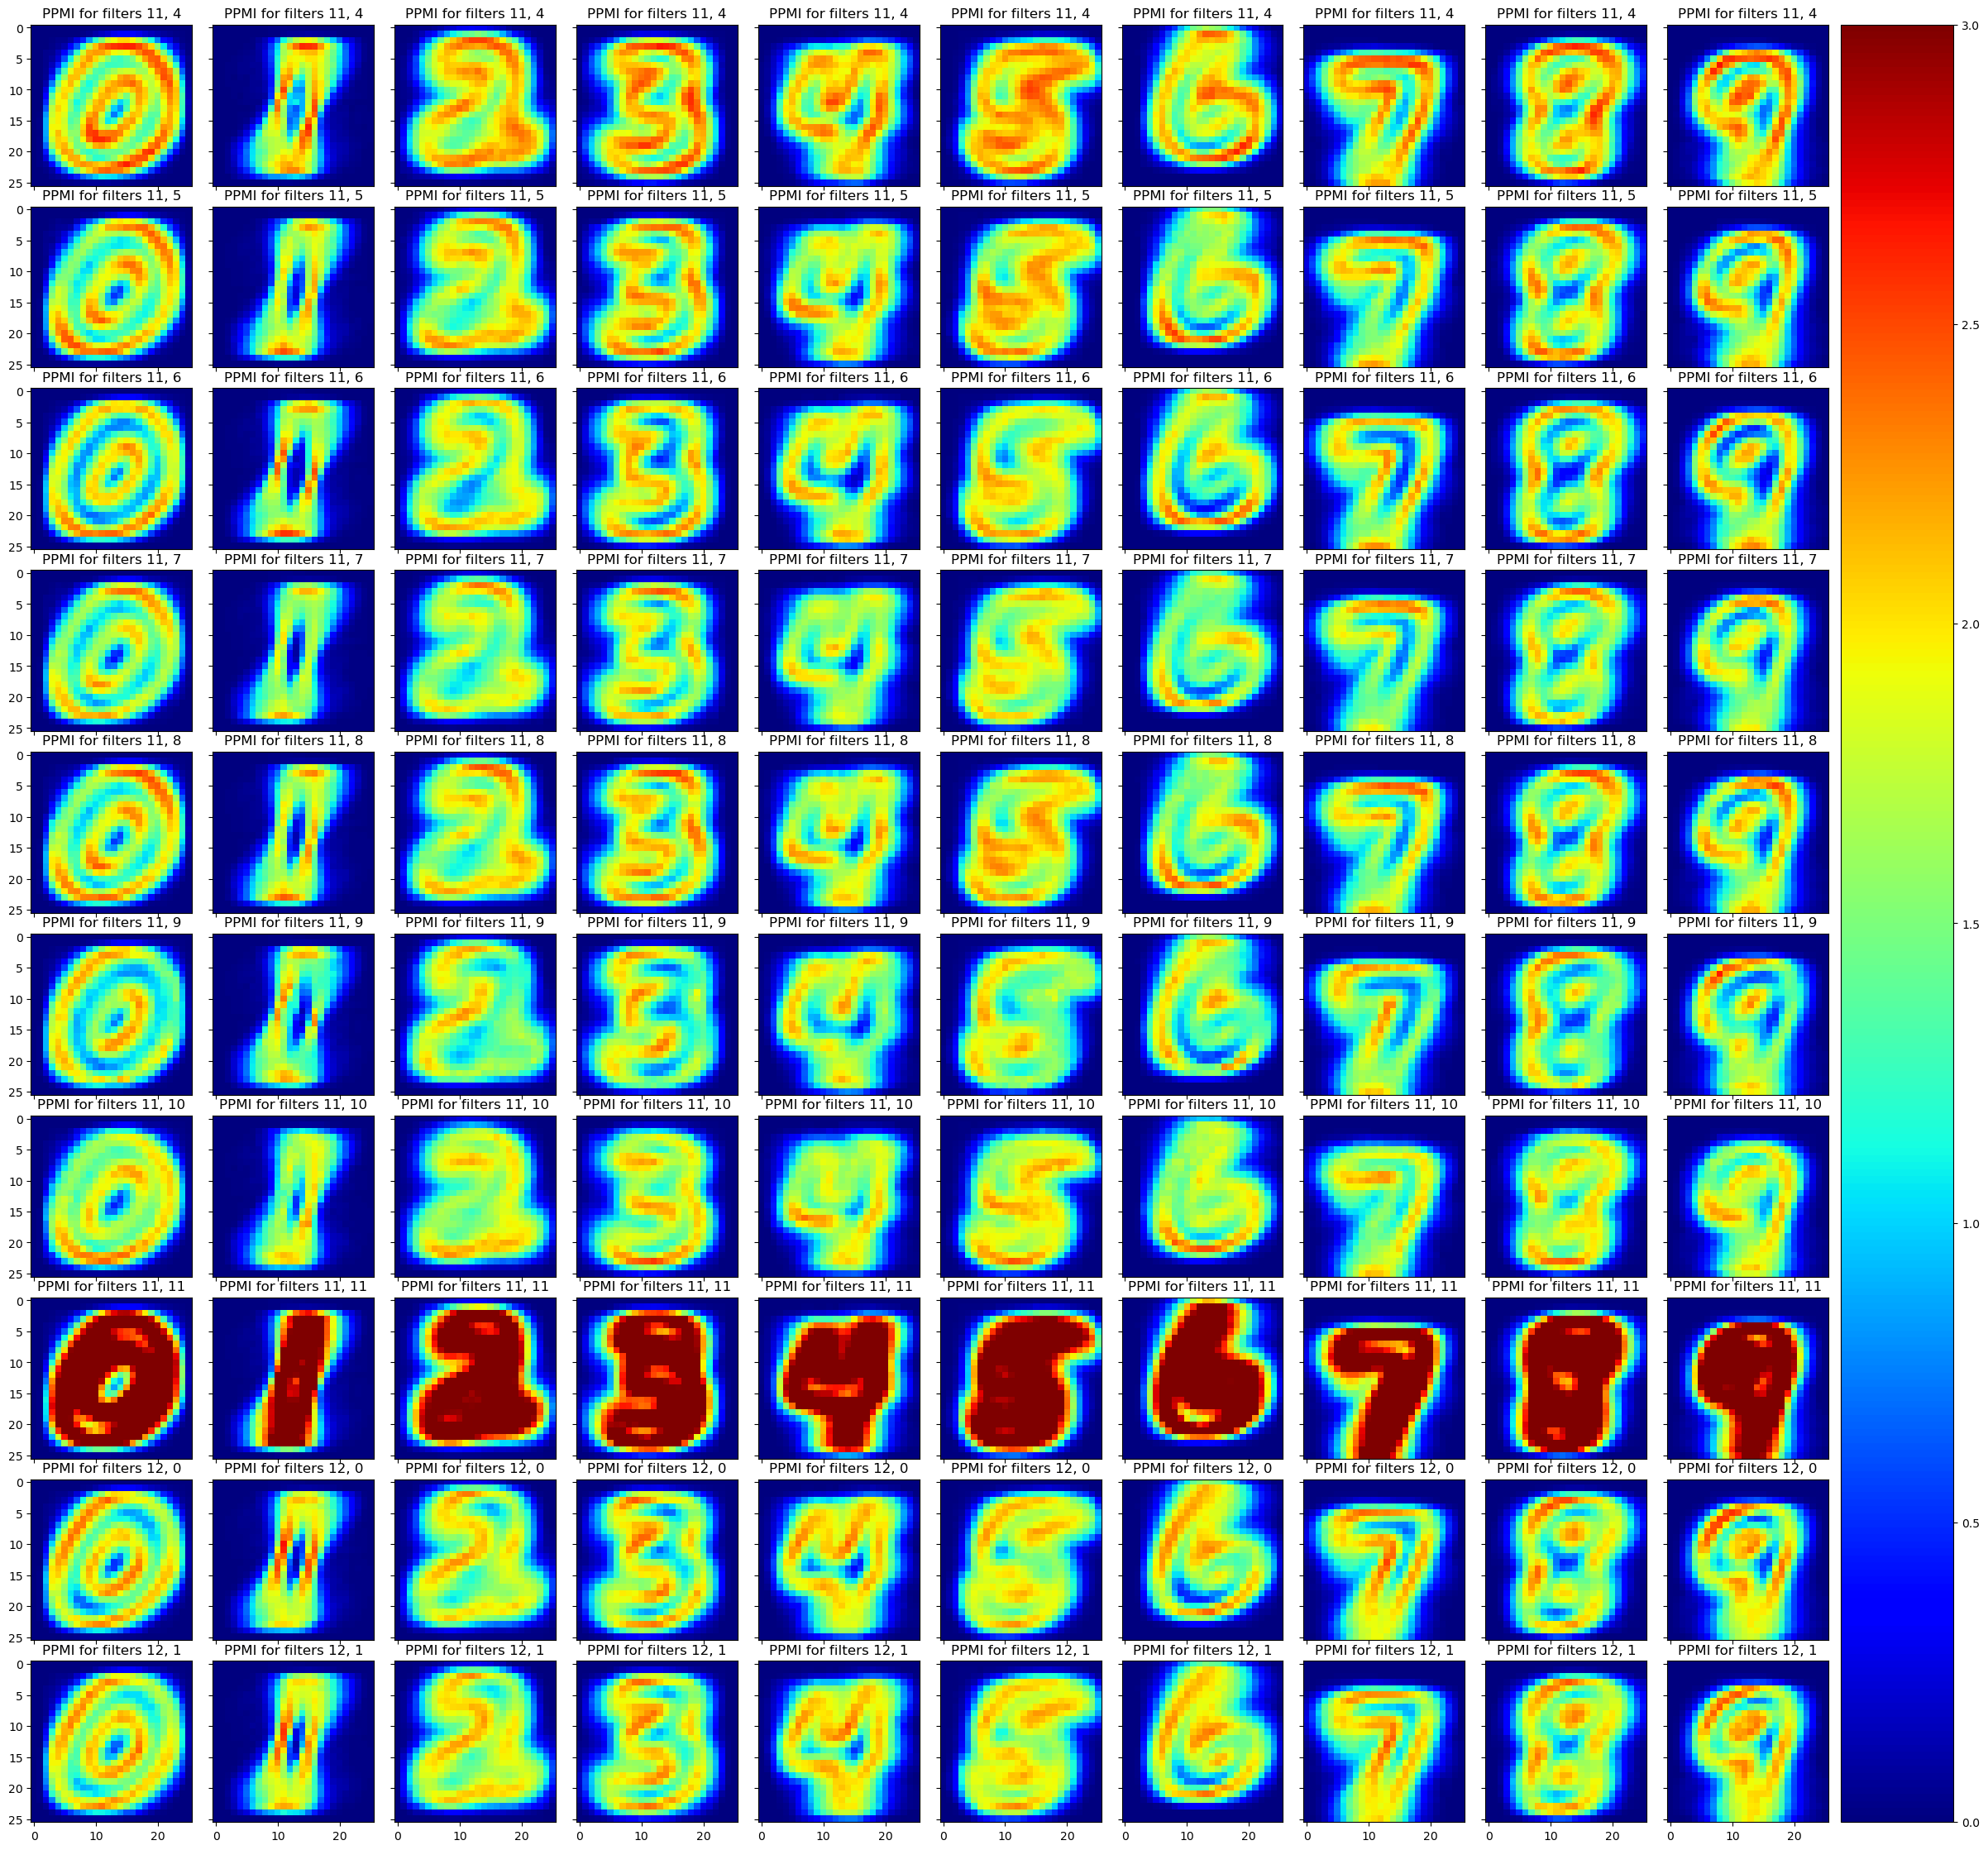

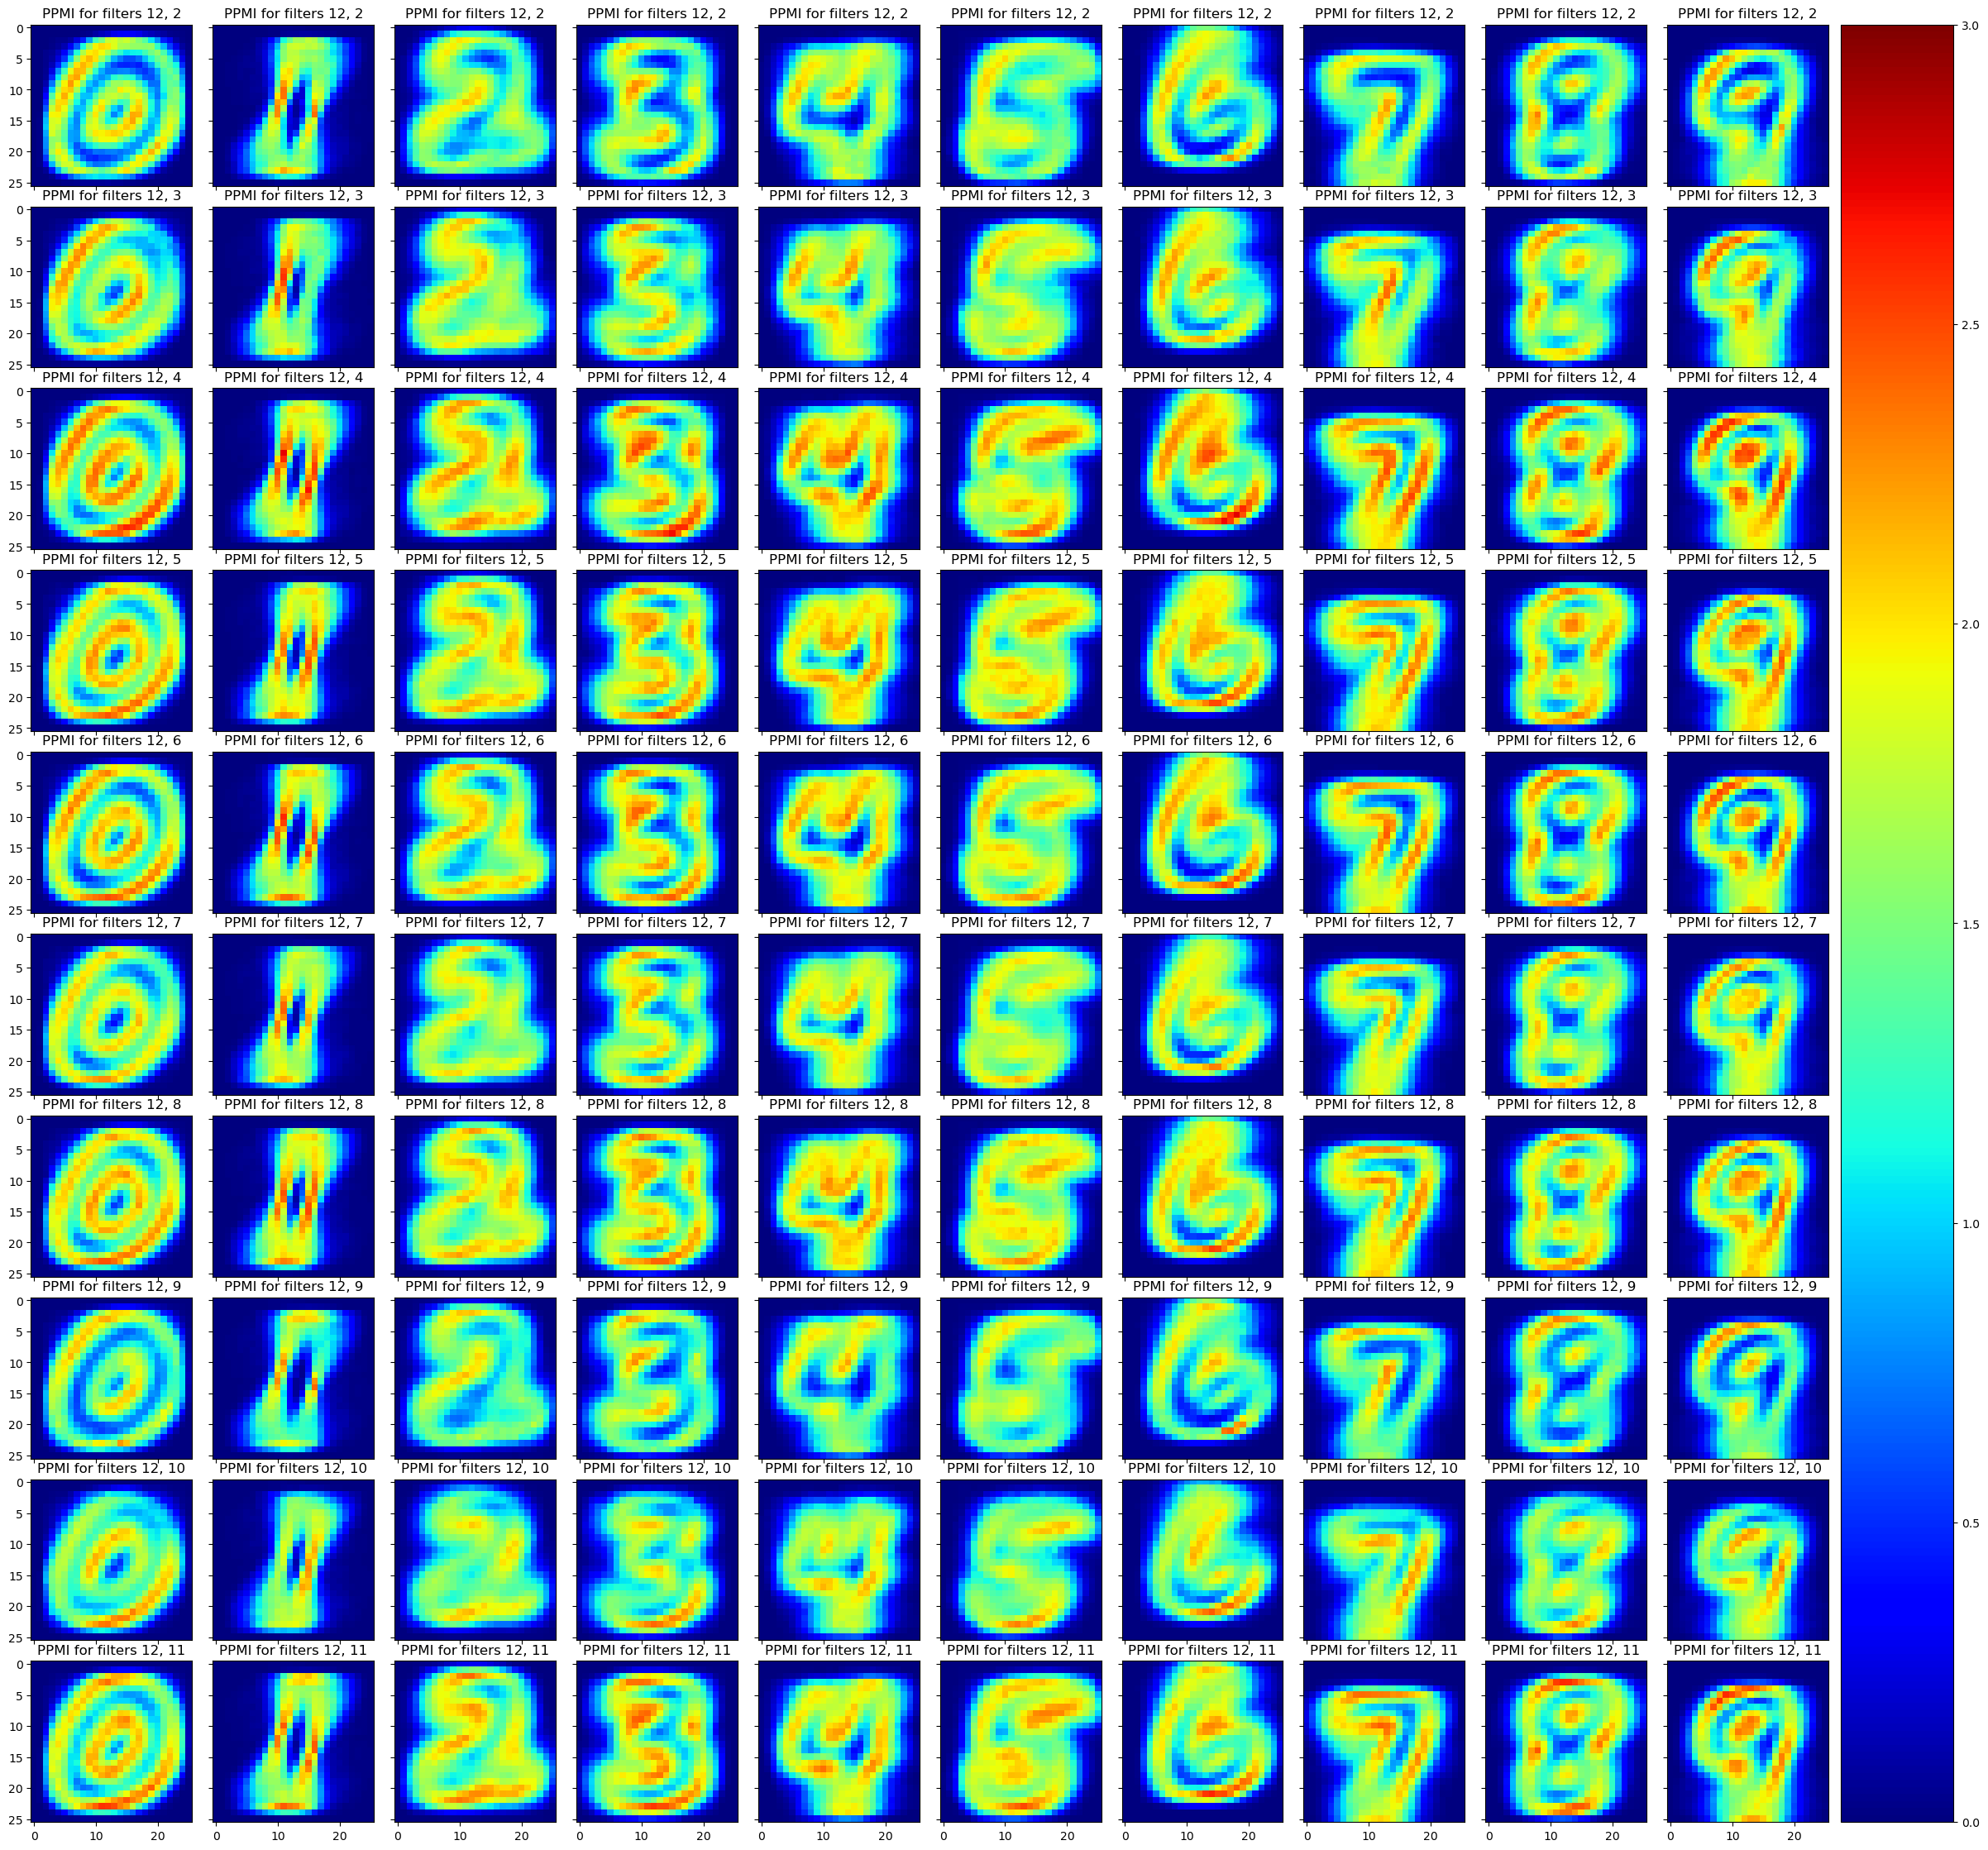

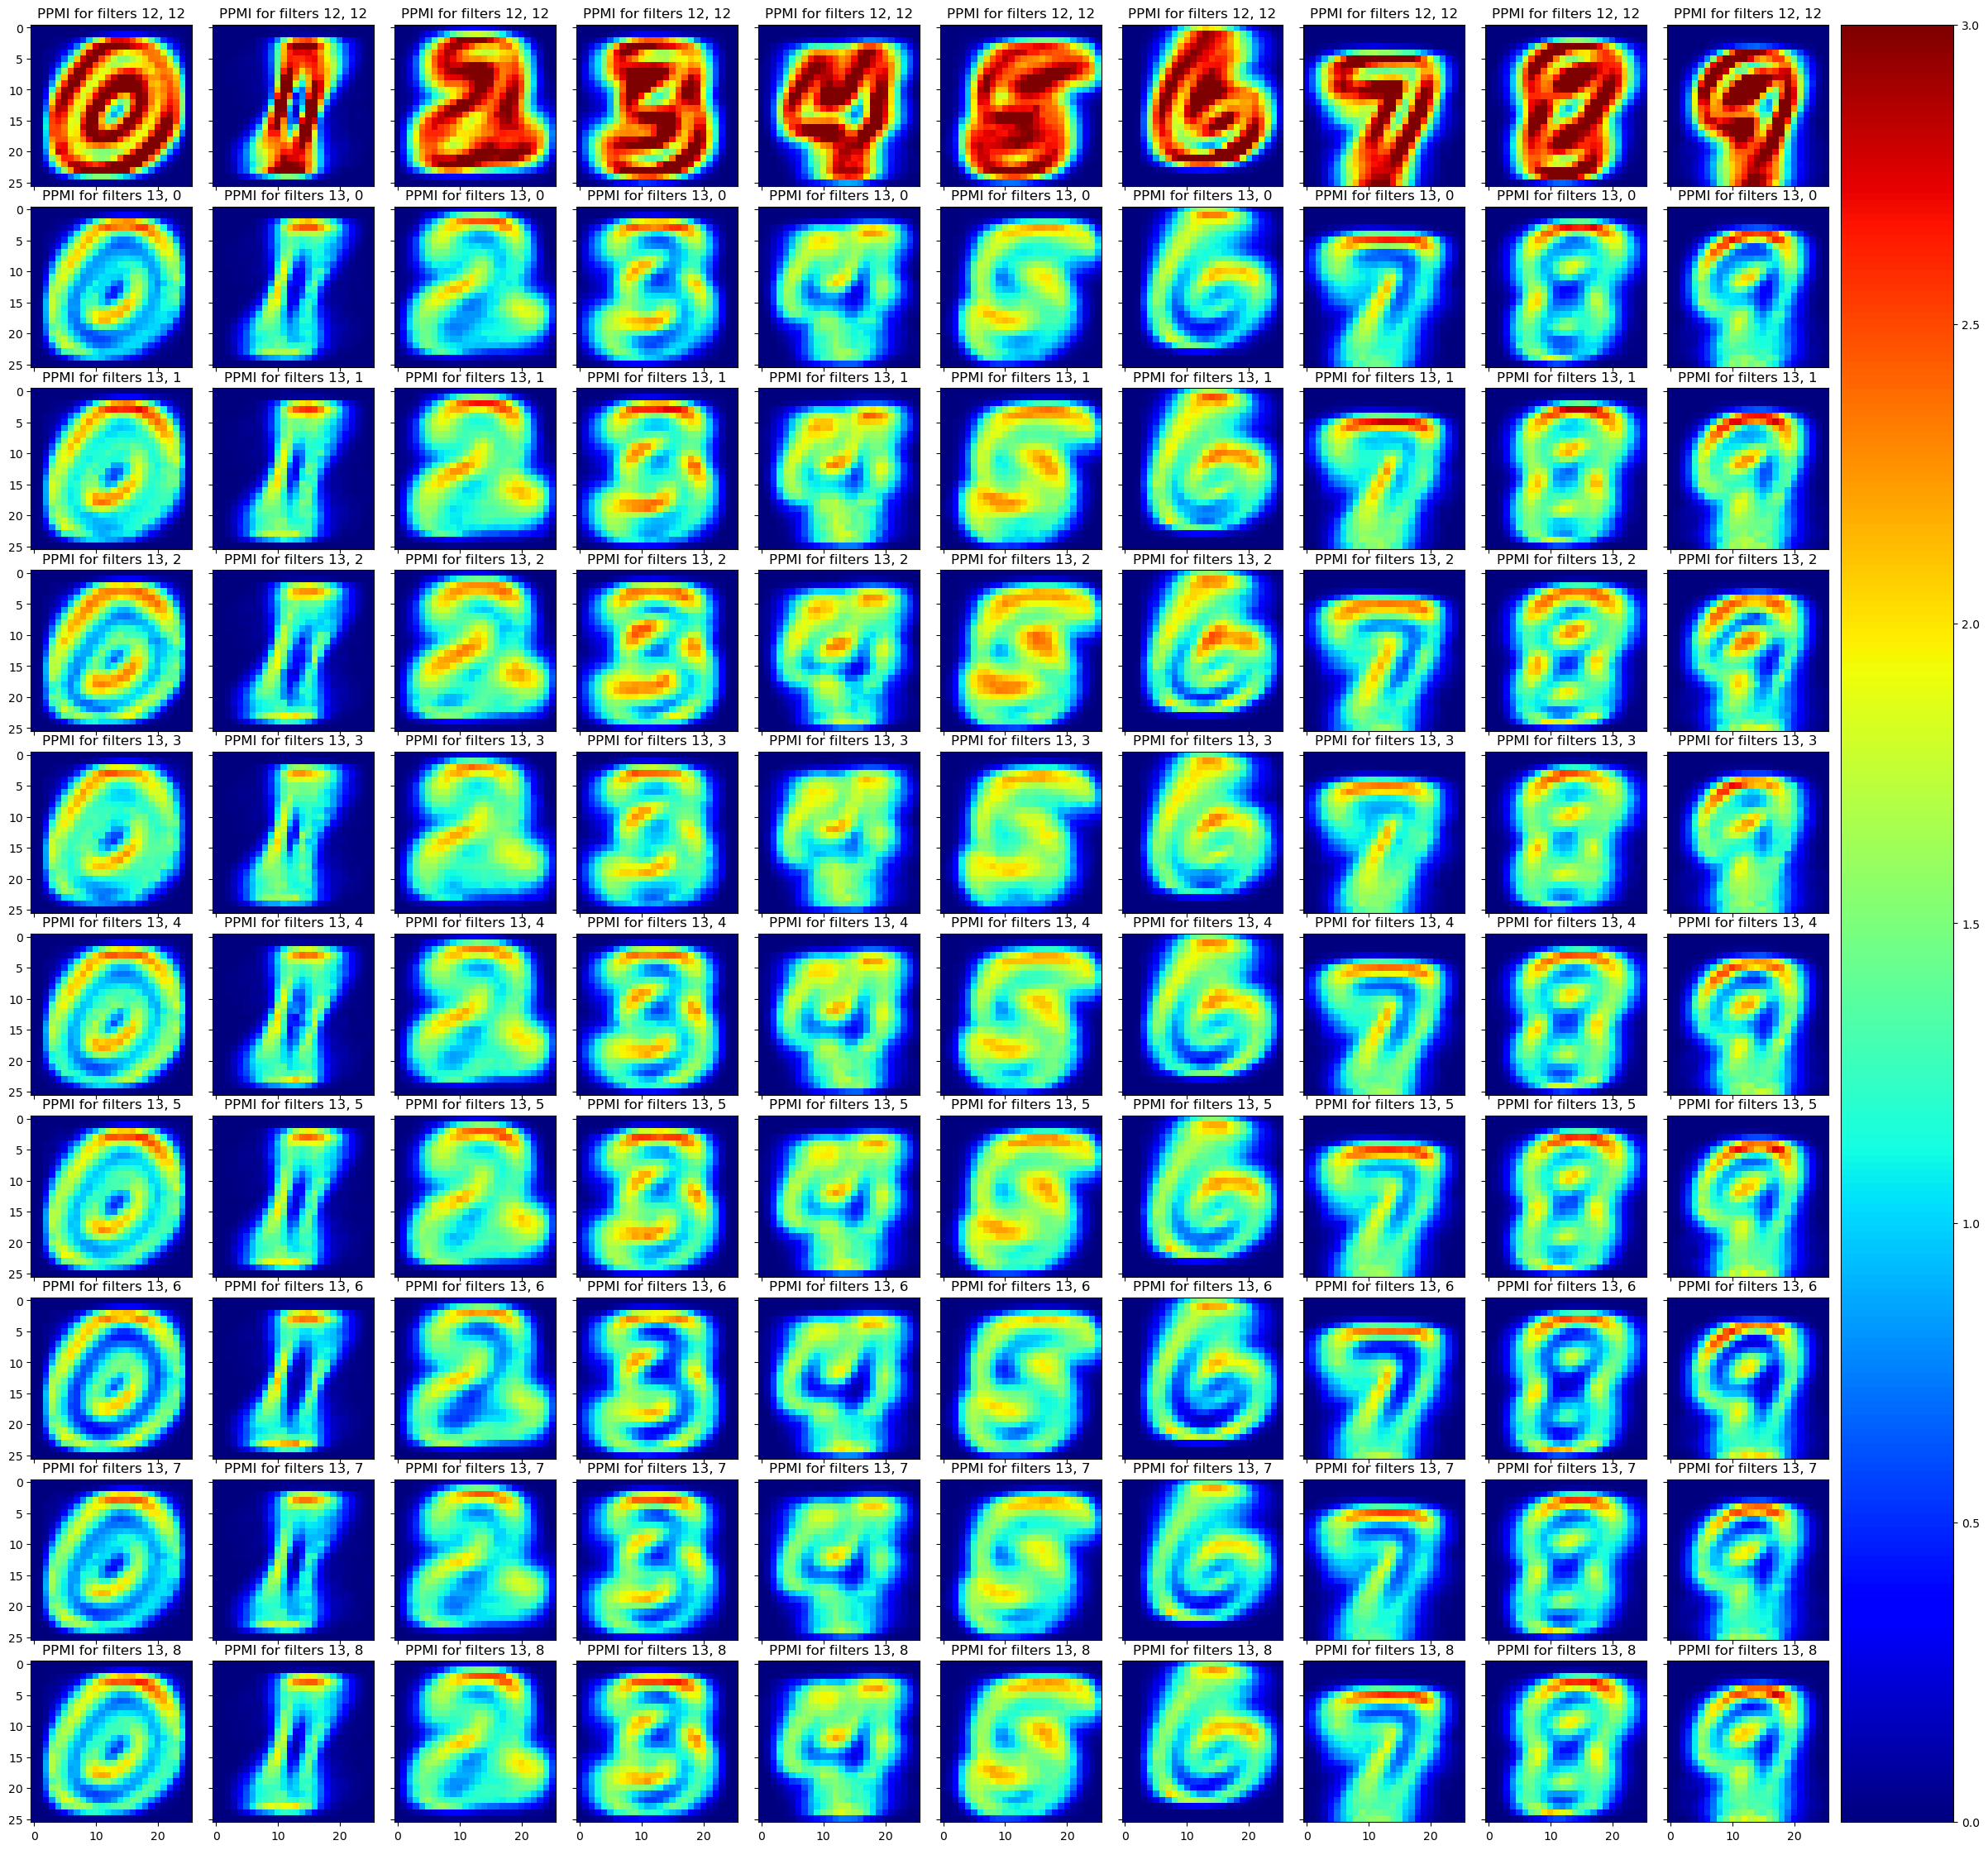

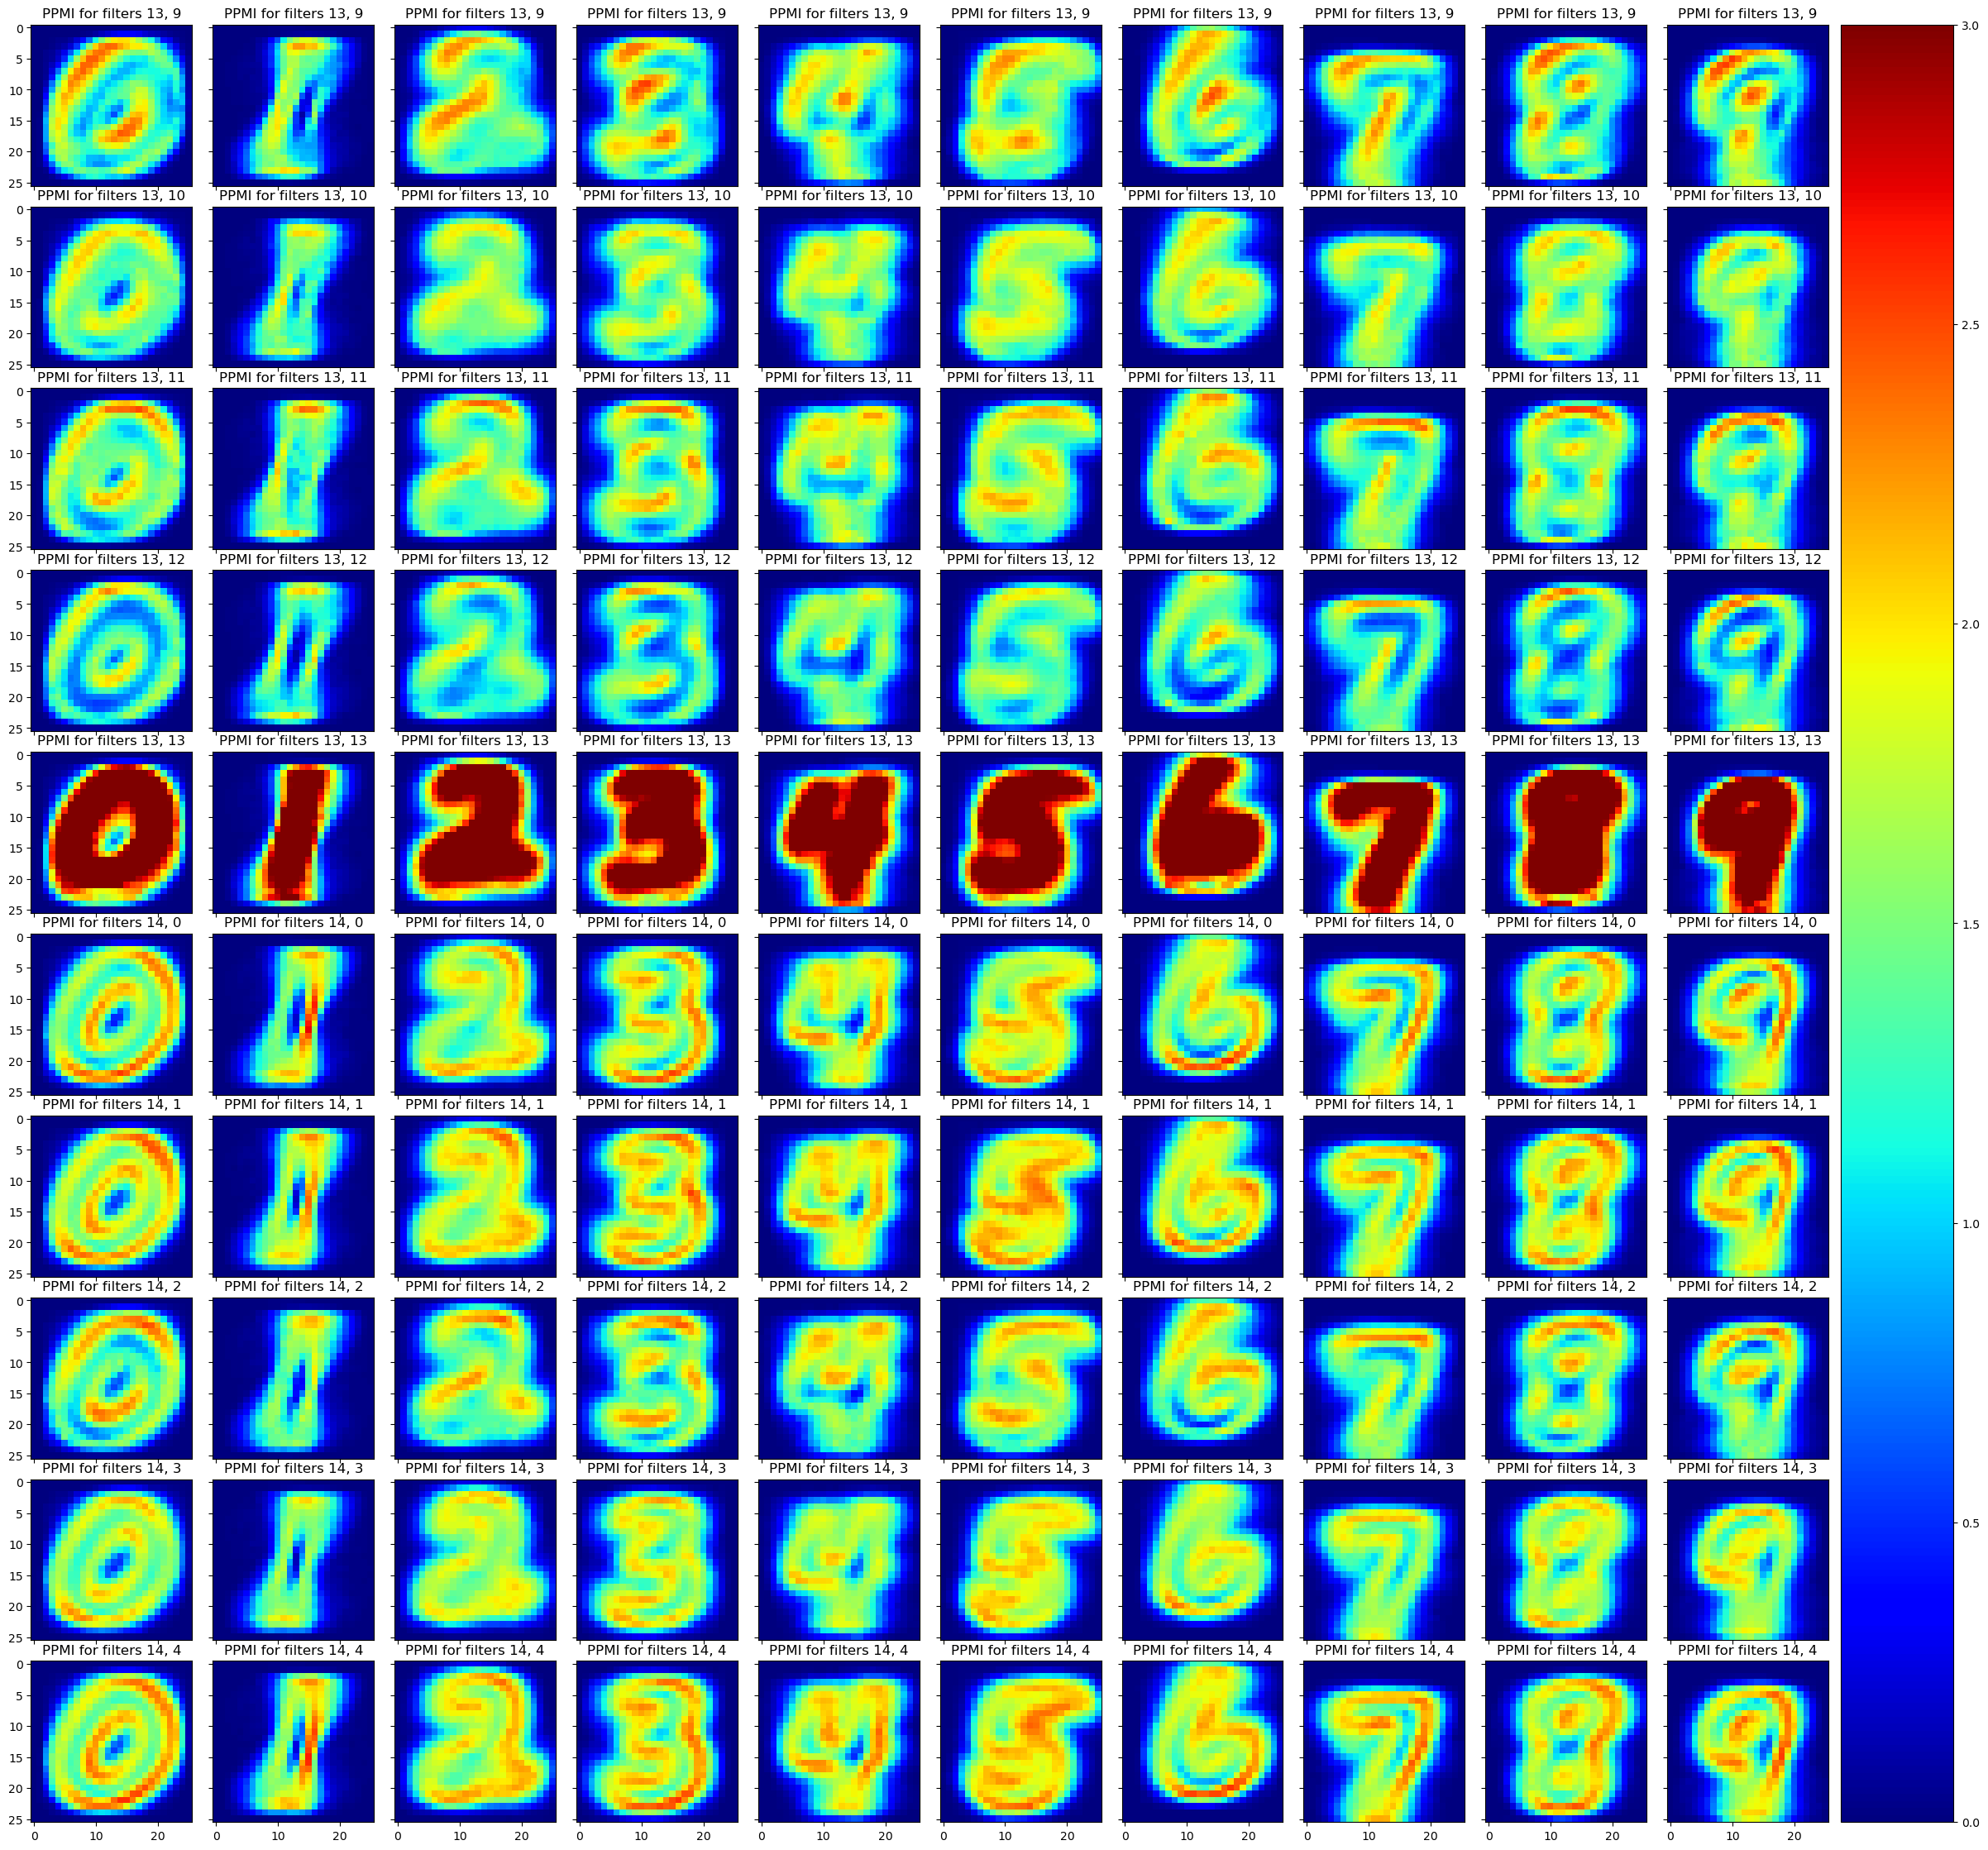

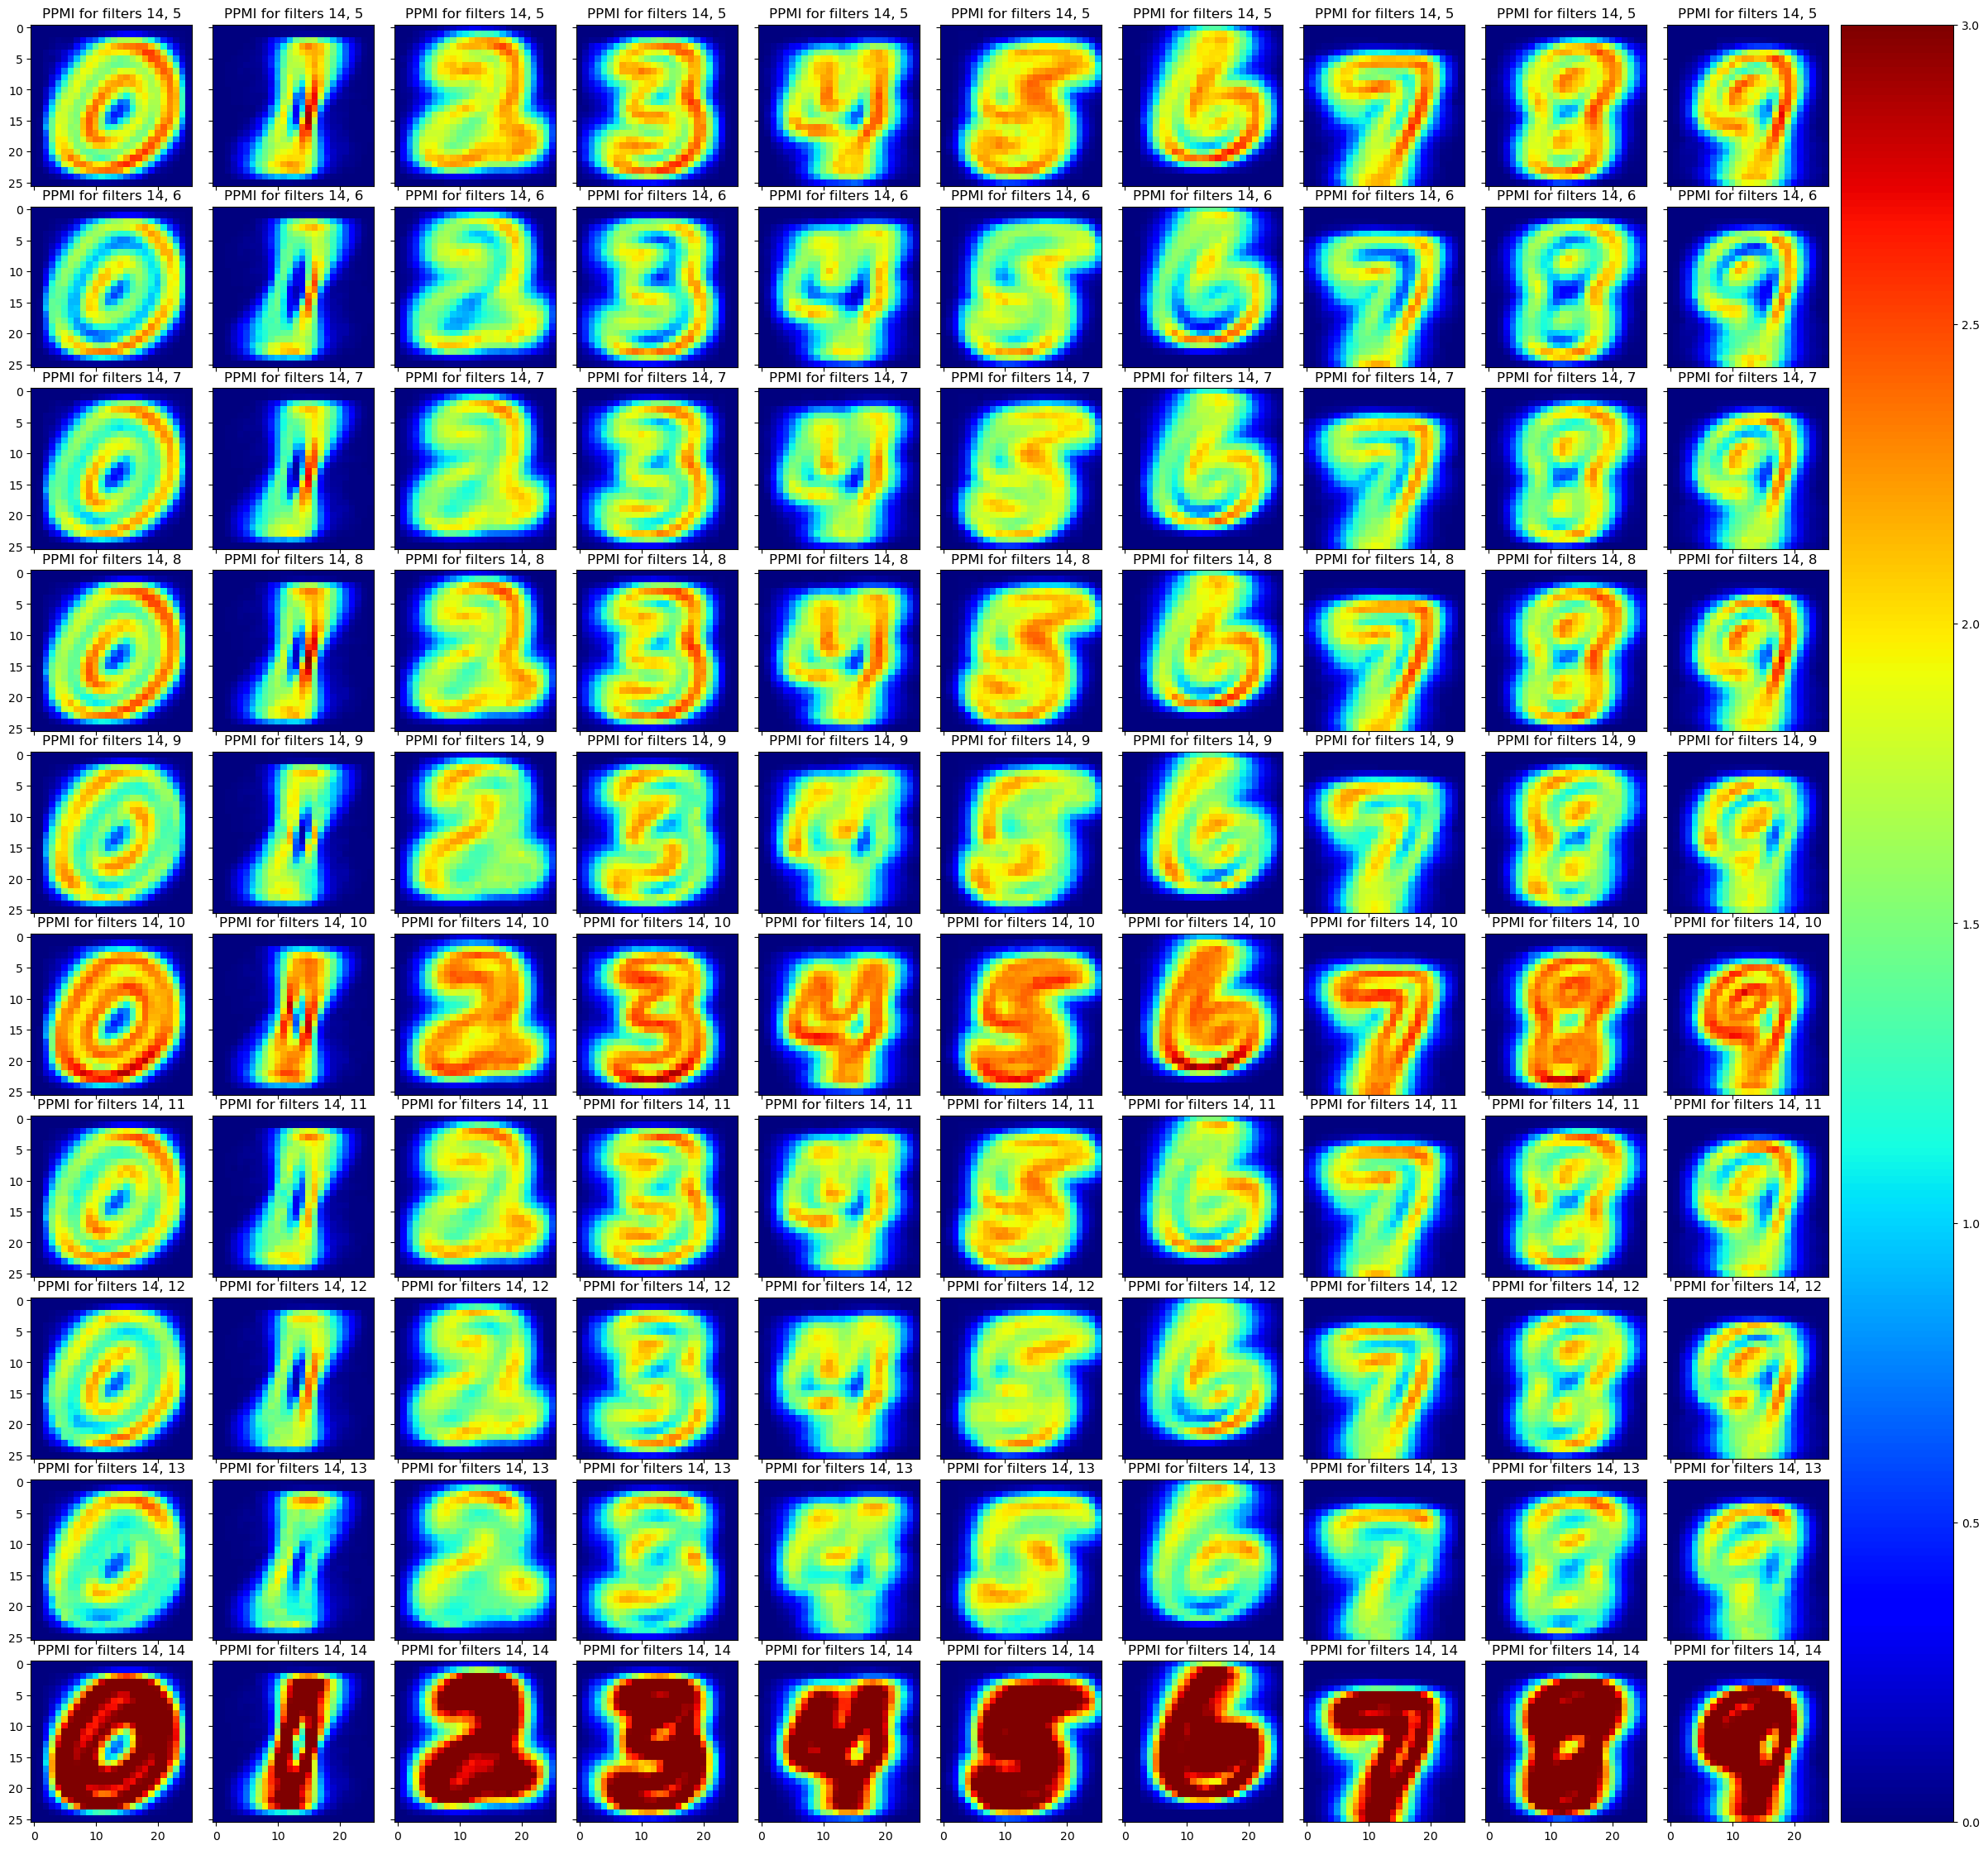

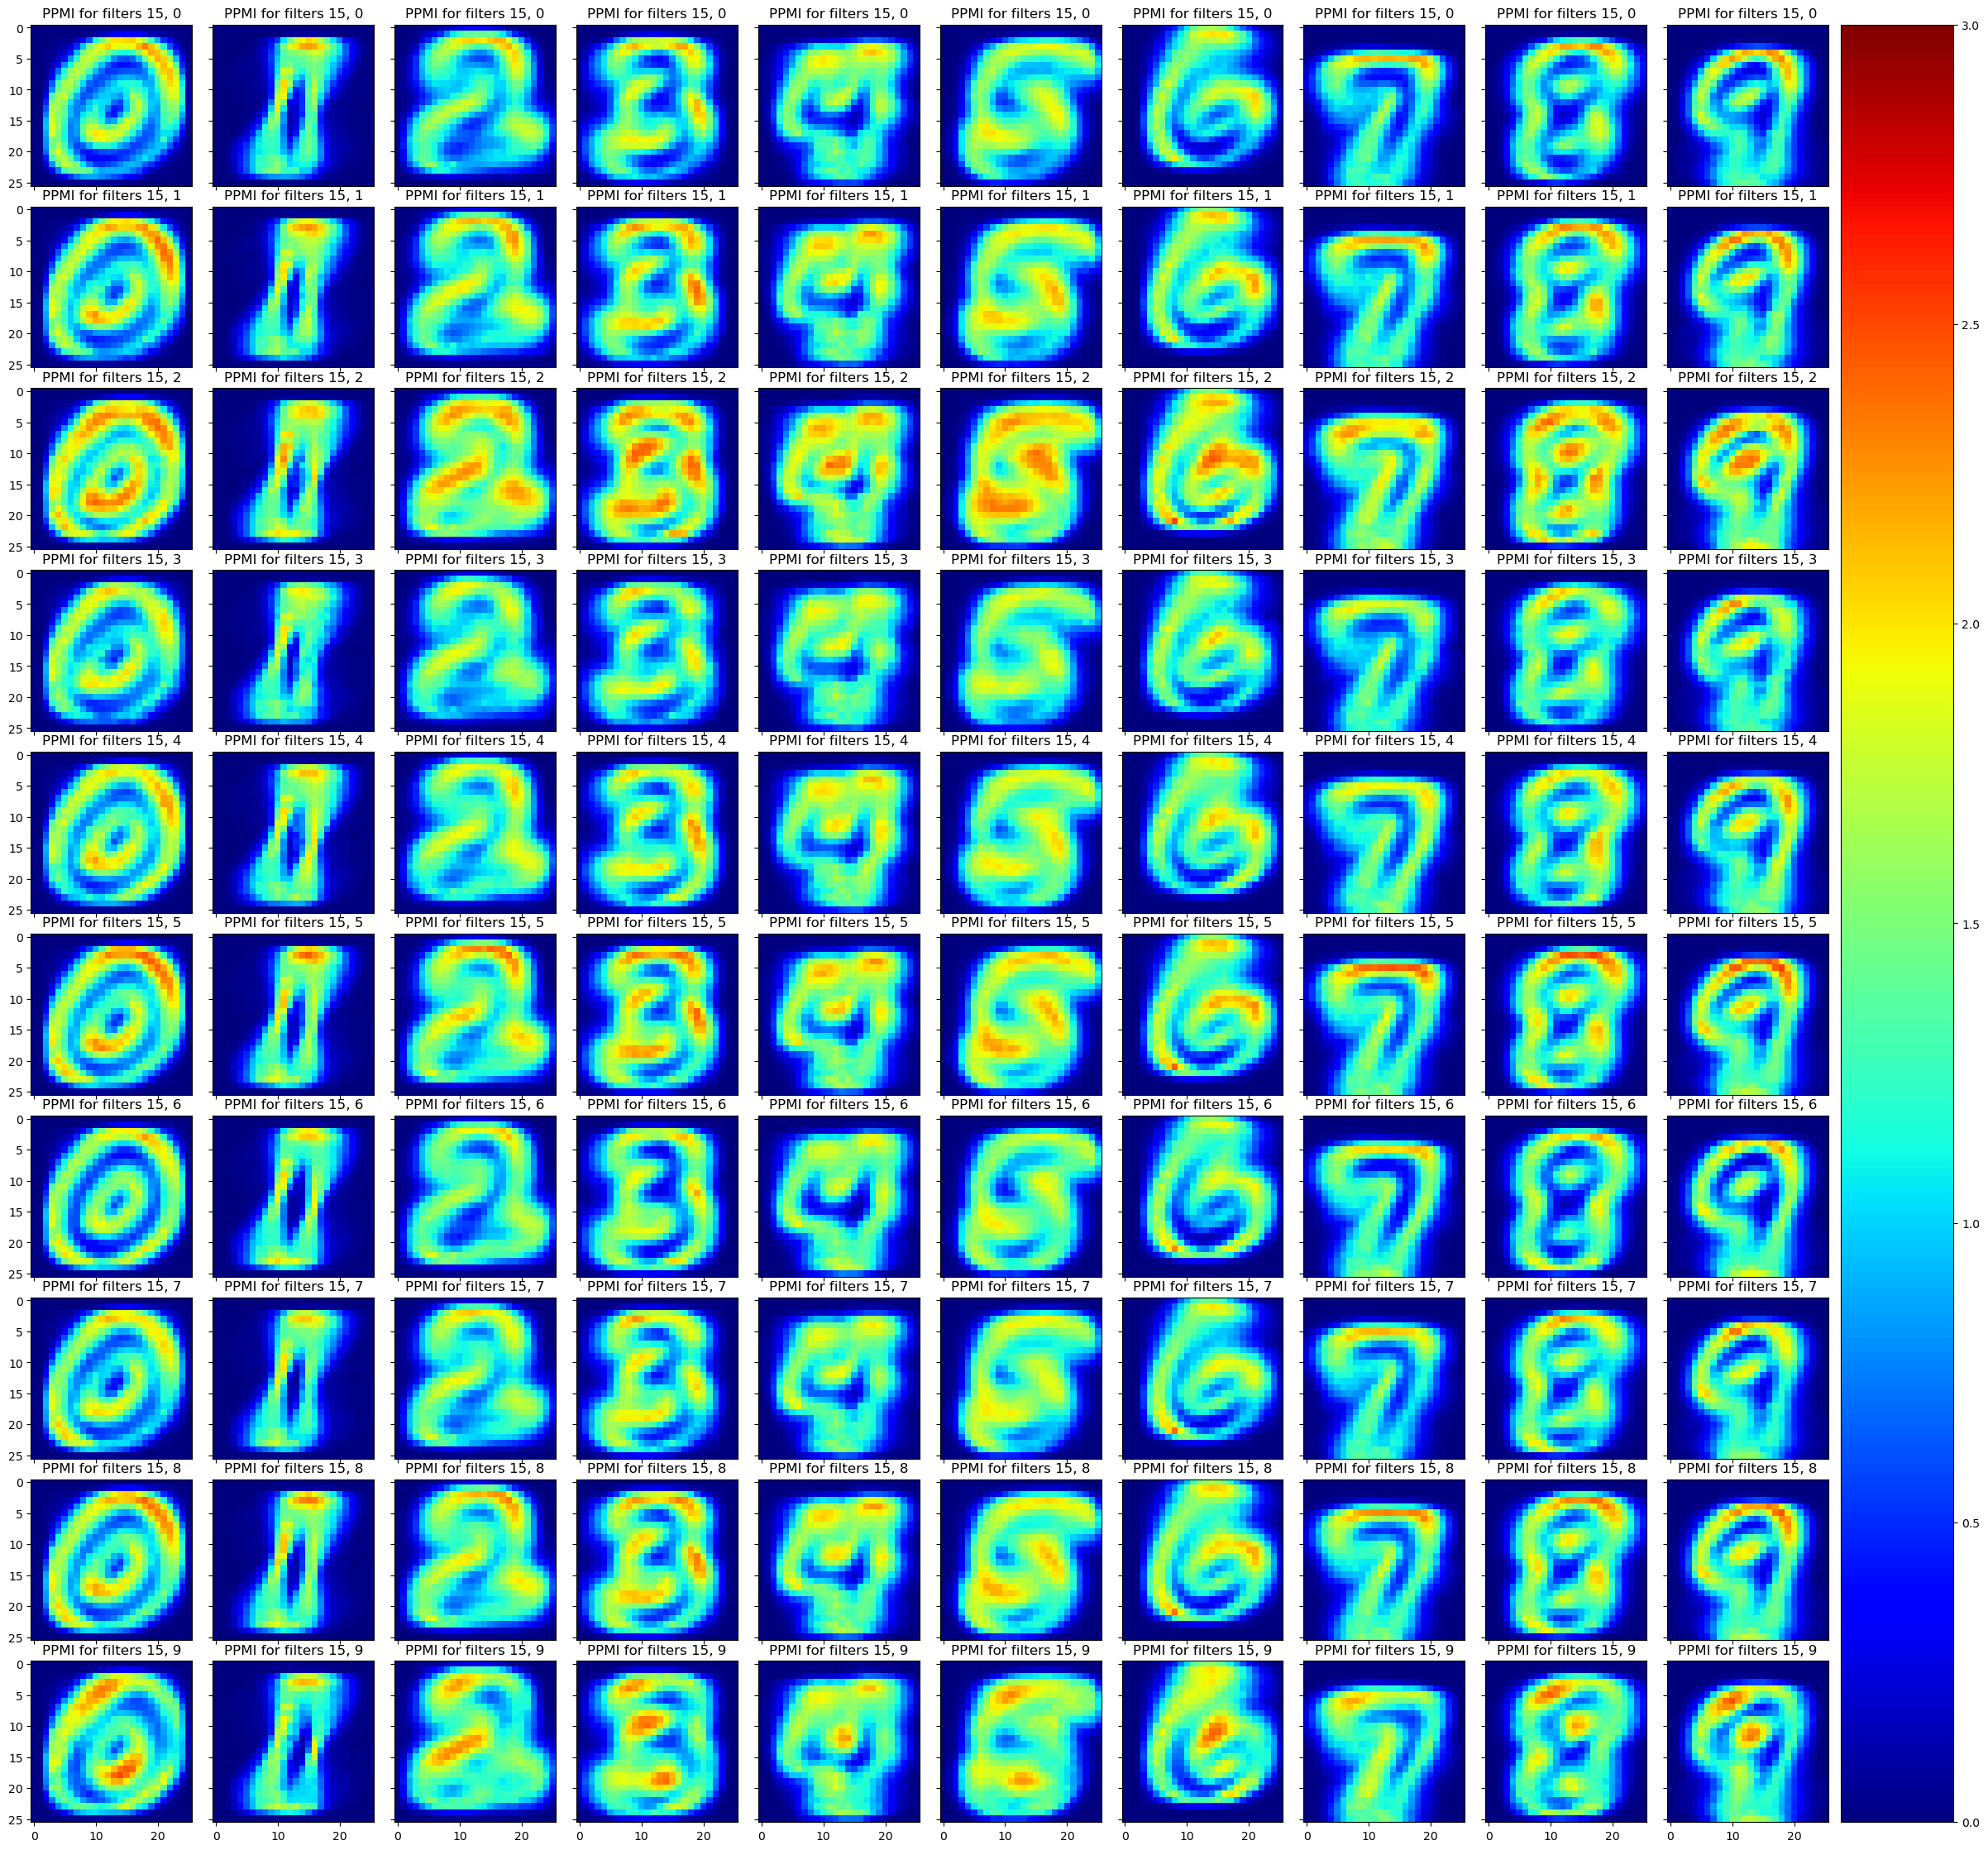

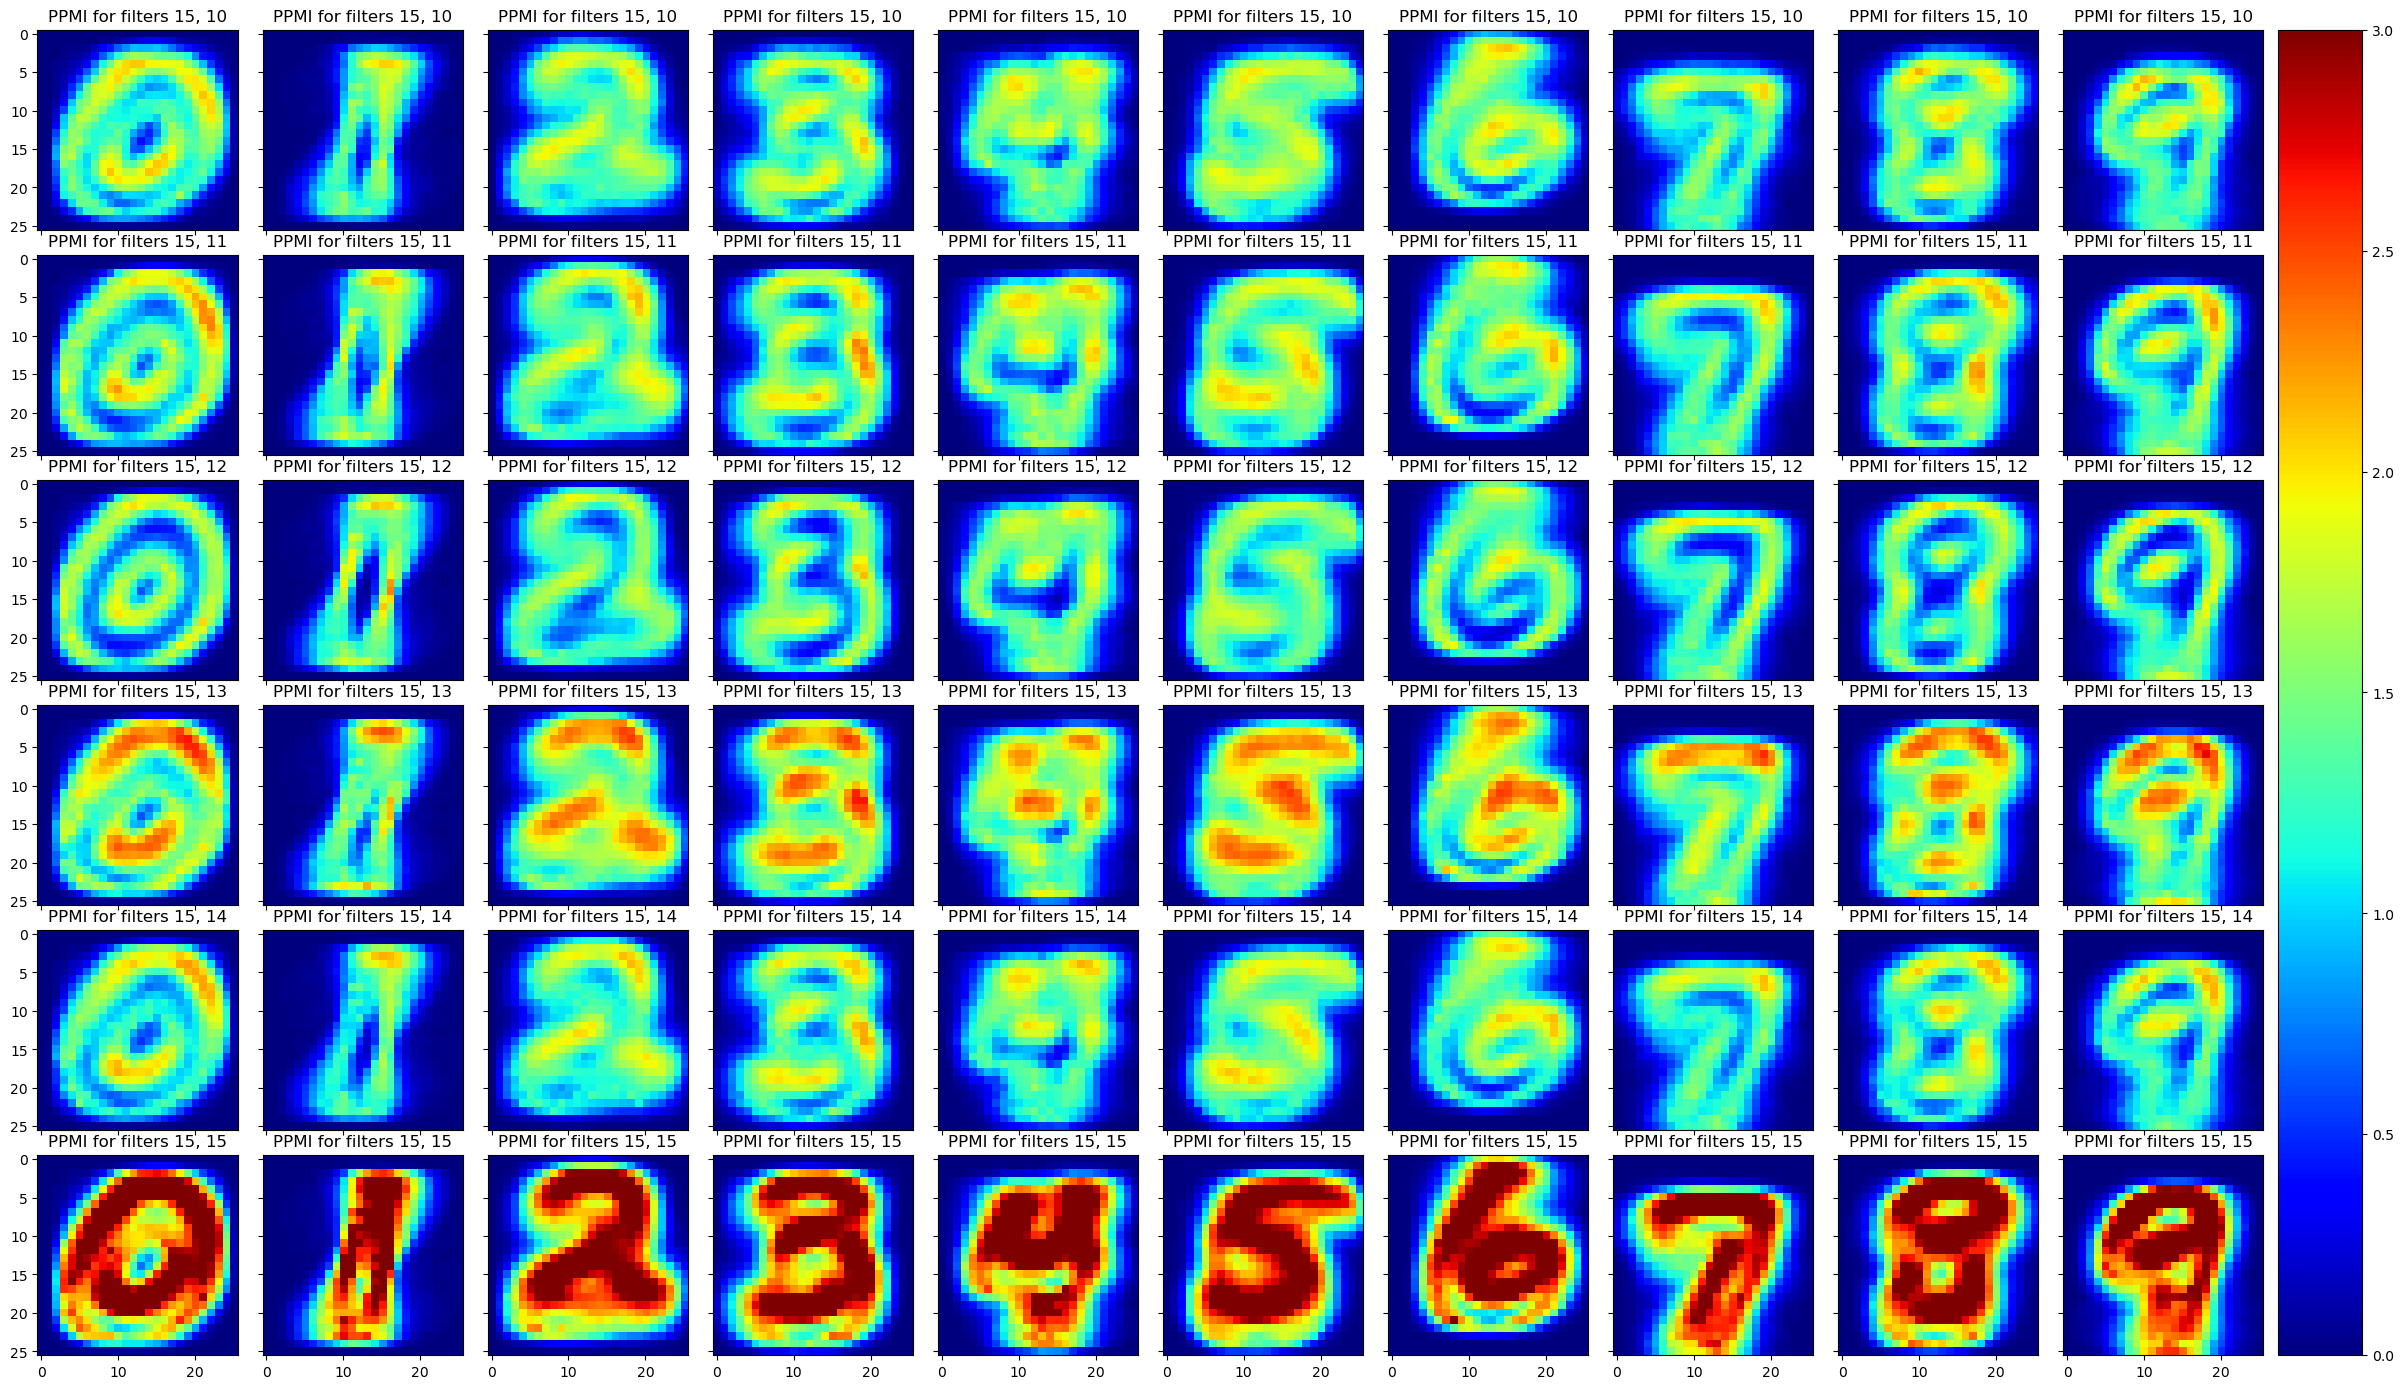

In [ ]:
for factor in range(0, 136, 10):
    
    if factor < 130:
        plot_PPMIs(factor)
    else:
        plot_PPMIs(factor, 6)
        
    print('Exporting figure', int(factor/10))

## Analysis of Class-Specific Input MIs

Let's analyze the class-to-class MI for MNIST data itself.

In [ ]:
test_data = testX[:,:,:,0]
test_data.shape

(10000, 28, 28)

In [ ]:
from random import sample
import time

def compute_MI_matrix_classes_input(inputs):
    k, l, all_data, labels = inputs
    
    # dimension of images
    d = 28*28
    
    MI_matrix = []
    
    class_1_data = all_data[labels == k]
    class_2_data = all_data[labels == l]
            
    tic = time.perf_counter()

    # reshape to d-vectors
    class_1_data = class_1_data.reshape([class_1_data.shape[0], d])
    class_2_data = class_2_data.reshape([class_2_data.shape[0], d])
    
    # find minimum sample size
    min_size = min(class_1_data.shape[0], class_2_data.shape[0])
    
    # randomly sample both down to min_size
    random_indices_1 = np.random.choice(class_1_data.shape[0], min_size, replace = False)
    random_indices_2 = np.random.choice(class_2_data.shape[0], min_size, replace = False)

    class_1_data = class_1_data[random_indices_1]
    class_2_data = class_2_data[random_indices_2]
    
    # initialize MI matrix
    MI_matrix = np.zeros([d, d])
        
    # creating a pool for multiprocessing
    pool = Pool(processes = None)

    # fill in MI matrix one row at a time
    for i in range(d):
        MI_matrix[i] = pool.map(calc_MI, ((class_1_data[:,i], class_2_data[:,j], 100) for j in range(d)))
   
    toc = time.perf_counter()
    print('Finished with MI matrix for classes %d and %d in %.2f seconds' % (k, l, toc - tic))
            
    return MI_matrix

In [ ]:
MI = compute_MI_matrix_classes_input((0, 1, test_data, testY_int))

Finished with MI matrix for classes 0 and 1 in 22.49 seconds


In [ ]:
MI_class_matrices = []

for k in range(10):
    for l in range(k+1):
        MI_class_matrices_kl = compute_MI_matrix_classes_input((k, l, test_data, testY_int))
        MI_class_matrices.append(MI_class_matrices_kl)

Finished with MI matrix for classes 0 and 0 in 22.70 seconds
Finished with MI matrix for classes 1 and 0 in 22.78 seconds
Finished with MI matrix for classes 1 and 1 in 23.28 seconds
Finished with MI matrix for classes 2 and 0 in 23.83 seconds
Finished with MI matrix for classes 2 and 1 in 22.59 seconds
Finished with MI matrix for classes 2 and 2 in 22.91 seconds
Finished with MI matrix for classes 3 and 0 in 22.80 seconds
Finished with MI matrix for classes 3 and 1 in 24.03 seconds
Finished with MI matrix for classes 3 and 2 in 22.79 seconds
Finished with MI matrix for classes 3 and 3 in 22.60 seconds
Finished with MI matrix for classes 4 and 0 in 22.62 seconds
Finished with MI matrix for classes 4 and 1 in 22.91 seconds
Finished with MI matrix for classes 4 and 2 in 22.53 seconds
Finished with MI matrix for classes 4 and 3 in 22.55 seconds
Finished with MI matrix for classes 4 and 4 in 22.92 seconds
Finished with MI matrix for classes 5 and 0 in 22.03 seconds
Finished with MI matrix 

In [ ]:
#with open('MI_class_input_matrices.pkl', 'wb') as f:
#    pkl.dump(MI_class_matrices, f) 

In [ ]:
import pickle as pkl

with open('../MI_class_input_matrices.pkl', 'rb') as f:
    MI_class_matrices = pkl.load(f)

In [ ]:
PPMI_class_matrices = []
j = 0

for k in range(10):
    PPMI_k = []
    
    for l in range(k+1):
        PPMI_k.append(np.diag(MI_class_matrices[j]).reshape([28,28]))
        
        j += 1
        
    PPMI_class_matrices.append(PPMI_k)

In [ ]:
# PPMI_class_matrices are the paired pixel MIs for each pair classes
#
# PPMI_class_matrices[i][j] will give you the paired-pixel MI matrices for
#
#     class i (i must be >= j)
#     class j

PPMI_class_matrices[4][2].shape

(28, 28)

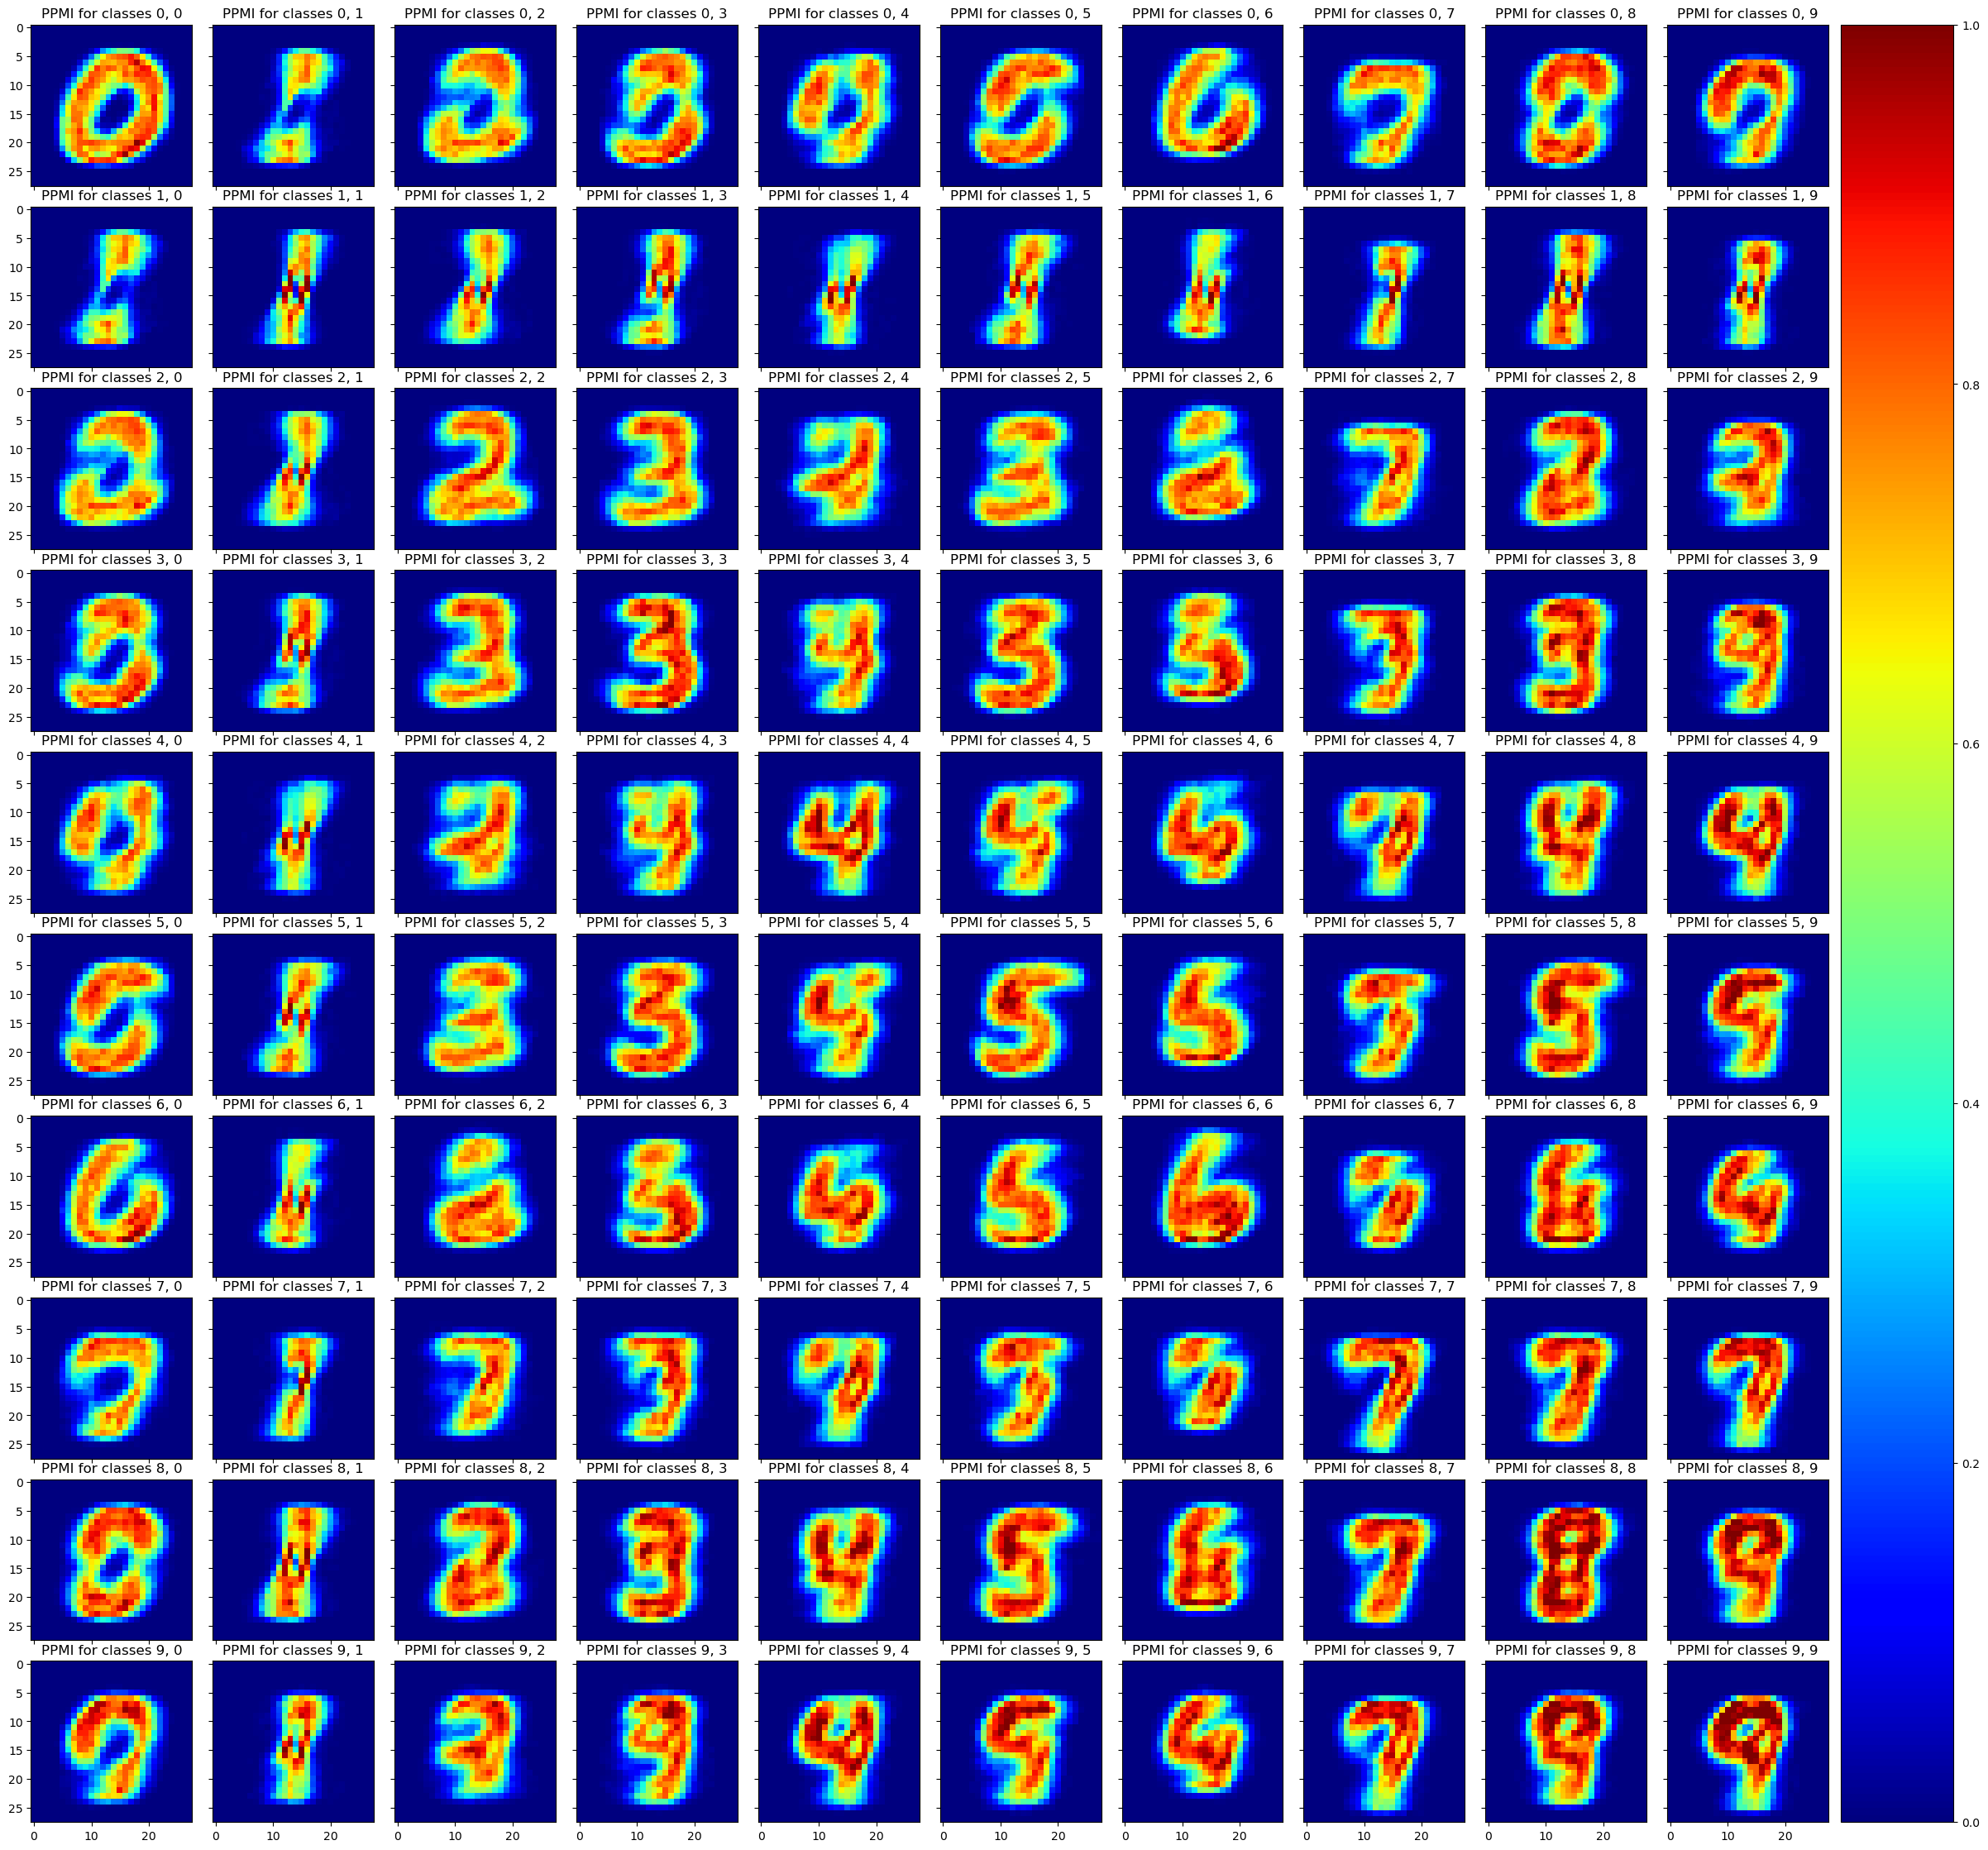

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
factor = 0
# Set up figure and image grid
fig = plt.figure(figsize=(30, 30))

grid = ImageGrid(fig,
                 111,
                 nrows_ncols=(10,10),
                 axes_pad=0.25,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
for i, ax in enumerate(grid, factor*grid._ncols):
    # find the row of the plot
    j = i // 10
    
    # find the column of the plot
    k = i % 10
    
    # grab the PPMI for the current pair of classes
    PPMI = PPMI_class_matrices[max(j,k)][min(j,k)]
    
    # plot the PPMI matrix
    im = ax.imshow(PPMI, vmin=0, vmax=1, cmap='jet')
    ax.set_title('PPMI for classes ' + str(j) + ', ' + str(k))
    
# add a colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

plt.show()
#plt.savefig('PPMIs_MNIST_class_pairs')